In [2]:
import pandas as pd
import datetime
import numpy as np
import pickle
from scipy import spatial
import itertools
from scipy import signal
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction import DictVectorizer
from sklearn.neighbors import KNeighborsRegressor
from sklearn import cross_validation
from sklearn.cross_validation import train_test_split
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn import pipeline
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.linear_model import LinearRegression
import operator
import string
from bokeh.layouts import gridplot
from bokeh.plotting import figure, show, output_file
from bokeh.embed import components 
import json
import dill
import re

In [3]:
business = pd.read_pickle('business_plus_reviews')
print business.head(0)
reviews_total = business['reviews']

Empty DataFrame
Columns: [hours.Thursday.open, hours.Friday.open, hours.Tuesday.open, categories, hours.Monday.open, name, review_count, state, hours.Friday.close, full_address, hours.Thursday.close, hours.Saturday.open, hours.Wednesday.close, open, city, stars, type, latitude, longitude, hours.Monday.close, hours.Tuesday.close, hours.Saturday.close, hours.Sunday.open, hours.Sunday.close, hours.Wednesday.open, neighborhoods, first_date, last_date, review_rate, days_open, is_restaurant, attributes_combined, reviews]
Index: []

[0 rows x 33 columns]


In [20]:
#direc = '/Users/minerva/Desktop/DataIncubator/miniprojects/ml/'        
direc = ''

cat_vocab = dill.load(open(direc+"category_vocab", "r"))
print cat_vocab
print ''

att_vocab = dill.load(open(direc+"attributes_vocab", "r"))
print att_vocab
print ''

rev_vocab = dill.load(open(direc+"reviews_vocab_1000", "r"))
print rev_vocab
print ''

#rev2_vocab = dill.load(open(direc+"reviews2_vocab_1000", "r"))
rev2_vocab = dill.load(open(direc+"reviews2_vocab", "r"))
print rev2_vocab
print ''

rev3_vocab = dill.load(open(direc+"reviews3_vocab_1000", "r"))
print rev3_vocab
print ''

{'': 0, 'Roofing': 762, 'Races ': 731, 'Truck Rental': 907, 'Drugstores': 287, 'Masonry/Concrete': 551, 'Wheel ': 956, 'Buffets': 134, 'Boating': 115, 'Auto Insurance': 62, 'Curry Sausage': 240, 'Endodontists': 306, 'Creperies': 233, 'Event Planning': 317, 'Canadian (New)': 152, 'Office Cleaning': 611, 'Teppanyaki': 880, 'Pretzels': 703, 'Occupational Therapy': 610, 'Organic Stores': 621, 'ATV Rentals/Tours': 5, 'Comedy Clubs': 204, 'Architects': 41, 'Ammo': 27, 'Breweries': 127, 'Climbing': 195, 'Herbs ': 432, 'Pet Boarding/Pet Sitting': 664, 'Child Care ': 182, 'Grocery': 403, 'Pet Adoption': 663, 'Apartments': 32, 'Hair Removal': 414, 'Dog Parks': 279, 'Adult Education': 11, 'Knife Sharpening': 504, 'Air Conditioning/HVAC': 16, 'Community Service/Non-Profit': 210, 'Bowling': 121, 'Restaurants': 755, 'DJs': 244, 'Formal Wear': 364, 'Hiking': 435, 'General Festivals': 386, 'Bankruptcy Law': 75, 'Cards ': 163, 'Delis': 257, 'Anesthesiologists': 29, 'Tanning': 859, 'Halal': 418, 'Canton

In [4]:
def att_to_dict(x):        
    att_list = x
    att_list = att_list.lstrip("&\s+")
    att_list = att_list.rstrip()
    #att_list = re.sub('\s+', '', att_list)
    att_list = re.split('\s*&\s*', att_list)
    one_array = np.ones(len(att_list))
    x_out = {cat_list:one_array for cat_list, one_array in zip(att_list, one_array)}
    return x_out

def cat_to_dict(x):        
    cat_list = x
    cat_list = re.sub("'", "", cat_list)
    cat_list = re.sub("\&", ",", cat_list)
    cat_list = cat_list.strip('\'')
    cat_list = cat_list.strip('\"')
    cat_list = cat_list.strip('[')
    cat_list = cat_list.strip(']')
    cat_list = re.split(',\s+', cat_list)
    one_array = np.ones(len(cat_list))
    x_out = {cat_list:one_array for cat_list, one_array in zip(cat_list, one_array)}
    return x_out

In [12]:
class CategVectTransformer(BaseEstimator, RegressorMixin):
    
    import numpy as np
    
    def __init__(self, column1=None, column2=None):
        self.column1 = 'categories'
        self.column2 = column2
        self.vocab = {'': 0, 'Roofing': 762, 'Races ': 731, 'Truck Rental': 907, 'Drugstores': 287, 'Masonry/Concrete': 551, 'Wheel ': 956, 'Buffets': 134, 'Boating': 115, 'Auto Insurance': 62, 'Curry Sausage': 240, 'Endodontists': 306, 'Creperies': 233, 'Event Planning': 317, 'Canadian (New)': 152, 'Office Cleaning': 611, 'Teppanyaki': 880, 'Pretzels': 703, 'Occupational Therapy': 610, 'Organic Stores': 621, 'ATV Rentals/Tours': 5, 'Comedy Clubs': 204, 'Architects': 41, 'Ammo': 27, 'Breweries': 127, 'Climbing': 195, 'Herbs ': 432, 'Pet Boarding/Pet Sitting': 664, 'Child Care ': 182, 'Grocery': 403, 'Pet Adoption': 663, 'Apartments': 32, 'Hair Removal': 414, 'Dog Parks': 279, 'Adult Education': 11, 'Knife Sharpening': 504, 'Air Conditioning/HVAC': 16, 'Community Service/Non-Profit': 210, 'Bowling': 121, 'Restaurants': 755, 'DJs': 244, 'Formal Wear': 364, 'Hiking': 435, 'General Festivals': 386, 'Bankruptcy Law': 75, 'Cards ': 163, 'Delis': 257, 'Anesthesiologists': 29, 'Tanning': 859, 'Halal': 418, 'Cantonese': 155, 'Breakfast': 125, 'Customized Merchandise': 241, 'Telecommunications': 876, 'Real Estate Law': 738, 'Chicken Wings': 181, 'Laser Eye Surgery/Lasik': 516, 'Videos ': 937, 'Hotels ': 466, 'Gold Buyers': 395, 'Antiques': 31, 'Equipment': 309, 'Pest Control': 662, 'Food Stands': 361, 'Orthodontists': 623, 'Shopping Centers': 793, 'Colleges ': 201, 'Stationery': 837, 'Mountain Biking': 588, 'Firearm Training': 341, 'Nail Salons': 597, 'Photo Booth Rentals': 671, 'Bike Rentals': 101, 'Elementary Schools': 299, 'Automotive': 66, 'Urologists': 916, 'Interior Design': 480, 'Cosmetic Surgeons': 221, 'Slovakian': 808, 'Consignment': 215, 'Lounges': 538, 'Guns ': 407, 'Persian/Iranian': 656, 'Shoe Repair': 790, 'Mongolian': 580, 'Animal Shelters': 30, 'Portuguese': 697, 'Cajun/Creole': 149, 'Appliances': 33, 'Hobby Shops': 440, 'Internet Law': 484, 'Gyms': 410, 'Bartending Schools': 82, 'Scandinavian': 769, 'Greek': 402, 'Zoos': 971, 'Hardware Stores': 421, 'Fitness ': 348, 'Art Galleries': 46, 'Battery Stores': 86, 'Watch Repair': 945, 'Limos': 531, 'Chinese': 186, 'Home Decor': 444, 'Food Trucks': 363, 'Resorts': 753, 'Bikes': 104, 'Estate Liquidation': 311, 'Alsatian': 22, 'Opera ': 616, 'Bed ': 92, 'Yoga': 970, 'Ophthalmologists': 617, 'Hookah Bars': 452, 'Middle Eastern': 570, 'Paddleboarding': 630, 'French': 366, 'Brazilian': 124, 'Building Supplies': 135, 'Landscape Architects': 512, 'Legal Services': 524, 'Recreation Centers': 741, '"Childrens Clothing"': 1, 'Empanadas': 302, 'Nutritionists': 607, 'Hungarian': 468, 'Stadiums ': 836, 'Escape Games': 310, 'Costumes': 224, 'Souvenir Shops': 819, 'Tea Supplies': 872, 'Fast Food': 331, 'Diners': 269, 'Sports Bars': 830, 'Campgrounds': 151, 'Russian': 764, 'Seafood Markets': 775, 'Tennis': 879, 'Bespoke Clothing': 99, 'Public Relations': 719, 'Vegetarian': 926, 'Instruction': 477, 'Piercing': 678, 'Chicken Shop': 180, 'Kosher': 507, 'Frozen Yogurt': 367, 'General Dentistry': 385, 'Flea Markets': 350, 'Brewing Supplies': 128, 'Social Clubs': 813, 'Pole Dancing Classes': 688, 'Trains': 897, '"Mens Clothing"': 2, 'Payroll Services': 648, 'Wine Tours': 966, 'Junk Removal ': 497, 'Currency Exchange': 239, 'Supply': 845, 'German': 388, 'Tobacco Shops': 889, 'Taiwanese': 857, 'Bus Tours': 138, 'Bath': 85, 'Laotian': 515, 'Video': 932, 'Mass Media': 552, 'Basque': 84, 'Towing': 892, 'Home Cleaning': 443, 'Public Services ': 720, 'Pilates': 679, 'Hypnosis/Hypnotherapy': 469, 'Taxidermy': 868, 'Nurseries ': 605, 'Vietnamese': 938, 'Personal Injury Law': 659, 'Video Game Stores': 934, 'Jet Skis': 493, 'Smog Check Stations': 809, 'Home Services': 448, 'Venezuelan': 929, 'Australian': 57, 'Food Court': 359, 'Pita': 680, 'Bingo Halls': 106, 'Gastroenterologist': 380, 'Rafting/Kayaking': 734, 'Marketing': 549, 'Mobile Dent Repair': 575, 'Educational Services': 294, 'Doulas': 285, 'Country Dance Halls': 228, 'Family Law': 325, 'Blow Dry/Out Services': 110, 'Framing': 365, 'Test Preparation': 881, 'Vacation Rentals': 922, 'Pizza': 681, 'Furniture Reupholstery': 373, 'Psychiatrists': 714, 'Engraving': 307, 'Archery': 40, 'Beer Garden': 95, 'RV Parks': 727, 'Web Design': 952, 'Planetarium': 682, 'Christmas Trees': 192, 'Seafood': 774, 'British': 130, 'Childbirth Education': 183, 'General Litigation': 387, 'Clowns': 196, 'Professional Sports Teams': 710, 'Transmission Repair': 900, 'Challenge Courses': 175, 'Pedicabs': 651, 'Screen Printing': 771, 'Beer Gardens': 96, 'Bail Bondsmen': 71, 'Baden': 69, 'Music Production Services': 592, 'Japanese': 491, 'Cosmetic Dentists': 220, 'Hot Dogs': 461, 'Gift Shops': 390, 'Festivals': 335, 'IP ': 470, 'Salvadoran': 766, 'Performing Arts': 652, 'Podiatrists': 687, 'Oriental': 622, 'Sandwiches': 767, 'Spray Tanning': 834, 'Shaved Ice': 788, 'Supplies': 844, 'Comic Books': 206, 'Pop-up Shops': 695, 'Accountants': 7, 'Chiropractors': 188, 'Dim Sum': 268, 'Summer Camps': 841, 'Office Equipment': 612, 'Hot Tub Service': 464, 'Pediatric Dentists': 649, 'Armenian': 44, 'Adult Entertainment': 12, 'Video Game Rental': 933, 'Ski ': 803, 'Fitness/Exercise Equipment': 349, 'Lighting Fixtures ': 530, 'Bistros': 107, 'Diagnostic Imaging': 265, 'Basketball Courts': 83, 'Bike Sharing': 103, 'Powder Coating': 700, 'Patisserie/Cake Shop': 646, 'Nightlife': 602, 'Auto Loan Providers': 63, 'Cocktail Bars': 197, 'Pet Training': 668, 'Service Stations': 781, 'Dive Bars': 273, 'Playgrounds': 684, 'Mortgage Brokers': 582, 'Landmarks ': 511, '"Womens Clothing"': 4, 'Pressure Washers': 702, 'Batting Cages': 87, 'Insulation Installation': 478, 'Hats': 422, 'Weight Loss Centers': 955, 'Accessories': 6, 'Watches': 946, 'Active Life': 8, 'Disc Golf': 270, 'Veggies': 927, 'Scottish': 770, 'Magazines': 542, 'Music Venues': 593, 'Hospitals': 458, 'Fabric Stores': 322, 'Window Washing': 959, 'Cardiologists': 162, 'Latin American': 519, 'Obstetricians ': 609, 'Art Supplies': 49, 'Butcher': 142, 'Acupuncture': 9, 'Airport Lounges': 18, 'Fruits ': 368, 'Wok': 968, 'Pet Services': 666, 'Guest Houses': 404, 'Distilleries': 272, 'Hair Salons': 415, 'Car Wash': 160, 'Lawyers': 521, 'Outdoor Gear': 627, 'Police Departments': 689, 'Cheesesteaks': 179, 'Lakes': 510, 'Kids Activities': 501, 'Estate Planning Law': 312, 'Tapas Bars': 861, 'Public Transportation': 721, 'Szechuan': 855, 'Contractors': 216, 'Midwives': 572, 'Hearing Aid Providers': 429, 'Hair Loss Centers': 413, 'Cambodian': 150, 'Mobile Phone Accessories': 576, 'Amateur Sports Teams': 24, 'Body Shops': 116, 'Cuban': 236, 'Snowboard Shops': 811, 'Dog Walkers': 280, 'Dance Schools': 249, 'Venues ': 930, 'CSA': 144, 'Museums': 590, 'Burgers': 136, 'Orthopedists': 624, 'Lingerie': 532, 'Departments of Motor Vehicles': 262, 'Event Planning ': 318, 'Private Investigation': 706, 'Solar Installation': 815, 'Employment Agencies': 303, 'Business Law': 141, 'Software Development': 814, 'Discount Store': 271, 'Uniforms': 911, 'Tattoo Removal': 865, 'Jazz ': 492, 'Furniture Repair': 372, 'Bavarian': 88, 'Pool Halls': 694, 'Juice Bars ': 496, 'Recycling Center': 742, 'Wine Tasting Room': 965, 'Electricians': 296, 'Heating ': 430, 'Real Estate': 736, 'Hospice': 457, 'Diving': 275, 'Professional Services': 709, 'Scuba Diving': 773, 'Universities': 912, 'Vintage ': 939, 'Cupcakes': 238, 'Sports Medicine': 832, 'Technical School': 874, 'RV Dealers': 726, 'Swimwear': 852, 'Trainers': 896, 'Food Tours': 362, 'Television Stations': 878, 'Go Karts': 394, 'Indian': 475, 'Golf Equipment': 397, 'Funeral Services ': 369, 'Fireplace Services': 342, 'Barbeque': 77, 'Massage': 553, 'Home Automation': 442, 'Transportation': 901, 'Home Theatre Installation': 450, 'Fireworks': 344, 'Retirement Homes': 756, 'Tax Services': 867, 'Afghan': 14, 'Boot Camps': 119, 'Adult': 10, 'Caterers': 173, 'Diagnostic Services': 266, 'Choirs': 190, 'Sugaring': 840, 'First Aid Classes': 345, 'Auto Detailing': 60, 'Art Schools': 48, 'Printing Services': 705, 'Skate Parks': 800, 'Bookstores': 118, 'Plumbing': 685, 'Taxis': 869, 'Bartenders': 81, 'Appliances ': 34, 'Repair': 752, 'Naturopathic/Holistic': 599, 'Auto Repair': 65, 'Laser Tag': 518, 'Demolition Services': 259, 'Fire Protection Services': 340, 'Peruvian': 661, 'Home Inspectors': 446, 'Wine Tasting Classes': 964, 'DVDs': 246, 'Shades ': 785, 'Rolfing': 761, 'Cooking Classes': 218, 'Martial Arts': 550, 'Ballet': 73, 'Proctologists': 708, 'Television Service Providers': 877, 'Water Parks': 949, 'High Schools': 434, 'Knitting Supplies': 505, 'Aquariums': 37, 'Champagne Bars': 176, 'Health ': 426, 'Hot Air Balloons': 460, 'Psychics ': 715, 'Spas': 821, 'Blinds': 108, 'Soccer': 812, 'Astrologers': 54, 'Piano Bars': 675, 'Religious Schools': 750, 'Laundry': 520, 'Egyptian': 295, 'Food': 357, 'Rheumatologists': 757, 'Assisted Living Facilities': 53, 'Livestock Feed ': 534, 'Cardio Classes': 161, 'Photographers': 672, 'Cemeteries': 174, 'Maternity Wear': 557, 'Tree Services': 904, 'Boat Repair': 114, 'Life Coach': 528, 'Print Media': 704, 'Beaches': 89, 'Surfing': 847, 'Ethnic Food': 314, 'Keys ': 500, 'Art Restoration': 47, 'Pub Food': 717, 'Prosthetics': 713, 'Tutoring Centers': 909, 'Reflexology': 744, 'Advertising': 13, 'Criminal Defense Law': 234, 'Neurologist': 600, 'Allergists': 21, 'Convenience Stores': 217, 'Comfort Food': 205, 'Surf Shop': 846, 'Refinishing Services': 743, 'Chocolatiers ': 189, 'Audiologist': 56, 'Orthotics': 625, 'Delicatessen': 256, 'Newspapers ': 601, 'Cheese Shops': 178, 'Waxing': 951, 'Rugs': 763, 'Party ': 640, 'RV Rental': 728, 'Gymnastics': 409, 'Fishing': 347, 'Language Schools': 514, 'Cafeteria': 148, 'Health Retreats': 428, 'Soul Food': 816, 'Kitchen ': 502, 'Blood ': 109, 'Tanning Beds': 860, 'Concept Shops': 214, 'Golf Lessons': 399, 'Gluten-Free': 393, 'Trampoline Parks': 898, 'Competitions': 211, 'Home Window Tinting': 451, 'Home ': 441, 'Supper Clubs': 842, 'Musicians': 596, 'Urgent Care': 915, 'Motorcycle Gear': 585, 'Sushi Bars': 849, 'Septic Services': 779, 'Tea Rooms': 871, 'Mailbox Centers': 545, 'Nanny Services': 598, 'Tool Rental': 890, 'Face Painting': 323, 'Travel Services': 903, 'Services': 782, 'Haitian': 417, 'Pool': 691, 'Permanent Makeup': 655, 'Saunas': 768, 'Hair Extensions': 412, 'Session Photography': 783, 'Recording ': 740, 'Movers': 589, 'Barbers': 78, 'Translation Services': 899, 'Screen Printing/T-Shirt Printing': 772, 'Food Delivery Services': 360, 'Garage Door Services': 375, 'Videographers': 936, 'Sporting Goods': 829, 'Amusement Parks': 28, 'Door Sales/Installation': 284, 'Swiss Food': 853, 'Shops': 794, 'Fertility': 334, 'Car Share Services': 158, 'Italian': 490, 'Personal Assistants': 657, 'Security Services': 776, 'Metal Fabricators': 568, 'Synagogues': 854, 'Gas ': 379, 'IT Services ': 471, 'Mediterranean': 566, 'Wholesale Stores': 957, 'Tax Law': 866, 'Department Stores': 261, 'Motorcycle Dealers': 584, 'Self Storage': 778, 'Tea': 870, 'Falafel': 324, 'Austrian': 58, 'Motorcycle Rental': 586, 'Education': 293, 'Tex-Mex': 882, 'Cosmetics ': 222, 'Internet Cafes': 483, 'Personal Chefs': 658, 'Irish Pub': 488, 'Caribbean': 165, 'Dance Clubs': 248, 'American (New)': 25, 'Investing': 486, 'Cosmetology Schools': 223, 'Airport Shuttles': 19, 'Alterations': 23, 'Coffeeshops': 199, 'Radio Stations': 732, 'Oil Change Stations': 614, 'Paintball': 633, 'Furniture Assembly': 371, 'Delivery Services': 258, 'Do-It-Yourself Food': 277, 'Video/Film Production': 935, 'Massage Schools': 554, 'Indonesian': 476, 'Shopping': 792, 'Historical Tours': 439, 'Hawaiian': 424, 'Teeth Whitening': 875, 'Nursing Schools': 606, 'Valet Services': 923, 'Utilities': 919, 'Iberian': 472, 'Windshield Installation ': 961, 'Sleep Specialists': 807, 'Wigs': 958, 'Ferries': 333, 'College Counseling': 200, 'Real Estate Agents': 737, 'Thai': 883, 'Horseback Riding': 456, 'Coffee ': 198, 'High Fidelity Audio Equipment': 433, 'Skin Care': 805, 'Uzbek': 920, 'Computer Repair': 212, 'Locksmiths': 537, 'Public Plazas': 718, 'Burmese': 137, 'Farmers Market': 328, 'African': 15, 'Magicians': 543, 'Outlet Stores': 628, 'Sewing ': 784, 'Mental Health': 567, 'Vape Shops': 924, 'Singaporean': 798, 'Vehicle Shipping': 928, 'Cinema': 194, 'Asian Fusion': 52, 'Mattresses': 558, 'Ethiopian': 313, 'Counseling ': 225, 'Gutter Services': 408, 'Mags': 544, 'Hot Pot': 462, 'Supplements': 843, 'Tours': 891, 'Embroidery ': 300, 'Gun/Rifle Ranges': 406, 'Pool Cleaners': 693, 'Makeup Artists': 546, 'Commercial Real Estate': 207, 'Turkish': 908, 'Laser Hair Removal': 517, 'Travel': 902, 'Live/Raw Food': 533, 'Bangladeshi': 74, 'Business Consulting': 140, 'Pet Groomers': 665, 'Gay Bars': 383, 'Preschools': 701, 'Rehearsal Studios': 747, 'Home Organization': 447, 'Internet Service Providers': 485, 'Officiants': 613, 'Southern': 818, 'Parenting Classes': 637, 'Beer Bar': 94, 'Registration Services': 745, 'Pediatricians': 650, 'Yelp Events': 969, 'Arts ': 51, 'Flowers': 354, 'Cooking Schools': 219, 'Rhinelandian': 758, 'Auto Parts ': 64, 'Osteopathic Physicians': 626, 'Community Centers': 208, 'Billiards': 105, 'Piano Services': 676, 'Physical Therapy': 674, 'University Housing': 913, 'Leisure Centers': 525, 'Mobile Phone Repair': 577, 'Airlines': 17, 'Post Offices': 698, 'Casinos': 171, 'Dive Shops': 274, 'Music ': 591, 'Pawn Shops': 647, 'Fire Departments': 339, 'Party Bus Rentals': 642, 'Hostels': 459, 'Castles': 172, 'Irrigation': 489, 'Candy Stores': 153, 'Gardening': 378, 'Kebab': 499, 'Wedding Chapels': 953, 'Hauling': 423, 'Vinyl Records': 940, 'Skate Shops': 801, 'Botanical Gardens': 120, 'Reiki': 748, 'Tires': 888, 'Handyman': 419, 'Walking Tours': 944, 'Wine Bars': 963, 'Life Insurance': 529, 'Hotels': 465, 'Golf Equipment Shops': 398, 'Career Counseling': 164, 'Shipping Centers': 789, 'Donuts': 283, 'Bagels': 70, 'Firewood': 343, 'House Sitters': 467, 'Painters': 634, 'Buddhist Temples': 133, 'Art Classes': 45, 'Carpenters': 167, 'Art Tours': 50, '"Mens Hair Salons"': 3, 'Bridal': 129, 'Colonics': 203, 'Walk-in Clinics': 943, 'Dominican': 281, 'Filipino': 336, 'Drywall Installation ': 289, 'Lactation Services': 509, 'Garden': 376, 'Boat Charters': 112, 'Massage Therapy': 555, 'Himalayan/Nepalese': 436, 'RV Repair': 729, 'Community Gardens': 209, 'Financial Advising': 337, 'Radiologists': 733, 'Medical Centers': 561, 'Glass ': 392, 'Tasting Classes': 863, 'Home Health Care': 445, 'Shoe Stores': 791, 'Shutters': 796, 'Jewelry Repair': 495, 'Lebanese': 523, 'Swimming Lessons/Schools': 850, 'Tai Chi': 856, 'Cycling Classes': 242, 'Luggage': 539, 'Credit Unions': 232, 'Medical': 560, 'Auction Houses': 55, 'Soup': 817, 'Car Rental': 157, 'Caricatures': 166, 'Hair Stylists': 416, 'Teachers': 873, 'Spine Surgeons': 827, 'Wedding Planning': 954, 'Auto Customization': 59, 'Gates': 382, 'Pumpkin Patches': 725, 'Buses': 139, 'American (Traditional)': 26, 'Barre Classes': 79, 'Ukrainian': 910, 'Mobile Phones': 578, 'Country Clubs': 227, 'Employment Law': 304, 'Observatories': 608, 'Arenas': 42, 'Motorcycle Repair': 587, 'Furniture Stores': 374, 'Appraisal Services': 35, 'Horse Boarding': 453, 'Chimney Sweeps': 185, 'Notaries': 603, 'Dry Cleaning ': 288, 'Street Vendors': 839, 'Tapas/Small Plates': 862, 'Fondue': 356, 'Signmaking': 797, 'Libraries': 526, 'Arabian': 38, 'Pets': 669, 'Churches': 193, 'Banks ': 76, 'Argentine': 43, 'Belgian': 98, 'Debt Relief Services': 255, 'Vocational ': 942, 'Propane': 711, 'Skating Rinks': 802, 'Emergency Rooms': 301, 'Day Camps': 252, 'Pasta Shops': 645, 'Eyewear ': 321, 'Hot Tub ': 463, 'Chips': 187, 'Karaoke': 498, 'Ear Nose ': 290, 'Party Supplies': 644, 'Shared Office Spaces': 787, 'Salad': 765, 'Toy Stores': 893, 'Paint Stores': 632, 'Day Care': 253, 'Marinas': 548, 'Perfume': 653, 'Data Recovery': 251, 'Ethnic Grocery': 315, 'Dermatologists': 263, 'Macarons': 540, 'Crafts': 231, 'Leather Goods': 522, 'Water Heater Installation/Repair': 948, 'Brunch': 131, 'Steakhouses': 838, 'Fashion': 330, 'Thrift Stores': 884, 'Gelato': 384, 'Fences ': 332, 'Beverage Store': 100, 'Fish ': 346, 'Doctors': 278, 'Desserts': 264, 'Puerto Rican': 723, 'Day Spas': 254, 'Sri Lankan': 835, 'Meditation Centers': 565, 'Polish': 690, 'Mosques': 583, 'Divorce ': 276, 'Backshop': 68, 'Entertainment': 308, 'Endocrinologists': 305, 'Furniture': 370, 'Historical Buildings': 438, 'Financial Services': 338, 'Pharmacy': 670, 'Palatine': 636, 'Matchmakers': 556, 'Moroccan': 581, 'Carpeting': 170, 'International': 482, 'Flowers ': 355, 'Musical Instrument Services': 594, 'Laboratory Testing': 508, 'Beer Hall': 97, 'Editorial Services': 292, 'Dentists': 260, 'Christmas Markets': 191, 'Government': 400, 'Horse Equipment Shops': 454, 'Train Stations': 895, 'Family Practice': 326, 'Machine ': 541, 'Gifts': 391, 'Bubble Tea': 132, 'Skydiving': 806, 'Crochet': 235, 'Carpet Installation': 169, 'Guitar Stores': 405, 'Rim Repair': 759, 'Farming Equipment': 329, 'Photography Stores ': 673, 'Shanghainese': 786, 'Food Banks': 358, 'Computers': 213, 'Airports': 20, 'Ski Resorts': 804, 'Eastern European': 291, 'Nurse Practitioner': 604, 'Blues': 111, 'Baby Gear ': 67, 'Local Services': 536, 'Plus Size Fashion': 686, 'Wineries': 967, 'Used': 917, 'Hindu Temples': 437, 'Eyelash Service': 320, 'Bars': 80, 'Unofficial Yelp Events': 914, 'Oncologist': 615, 'Countertop Installation': 226, 'Cabinetry': 146, 'Ice Cream ': 473, 'Meat Shops': 559, 'Driving Schools': 286, 'Periodontists': 654, 'Musical Instruments ': 595, 'Veterinarians': 931, 'Health Markets': 427, 'Event Photography': 316, 'Smoothies': 810, 'Lice Services': 527, 'Henna Artists': 431, 'Shredding Services': 795, 'Tattoo': 864, 'Electronics Repair': 298, 'Beauty Supply': 91, 'Pool ': 692, 'Carpet Cleaning': 168, 'Boat Dealers': 113, 'Water Delivery': 947, 'Courthouses': 230, 'Race Tracks': 730, 'Real Estate Services': 739, 'Damage Restoration': 247, 'Korean': 506, 'Pakistani': 635, 'Local Flavor': 535, 'Farm Equipment Repair': 327, 'Jewelry': 494, 'Head Shops': 425, 'Pet Stores': 667, 'Check Cashing/Pay-day Loans': 177, 'Security Systems': 777, 'Brasseries': 123, 'Cultural Center': 237, 'Horse Racing': 455, 'Vegan': 925, 'Piano Stores': 677, 'Pubs': 722, 'Landscaping': 513, 'Mini Golf': 573, 'Donairs': 282, 'Dialysis Clinics': 267, 'Gastropubs': 381, 'Rest Stops': 754, 'Car Stereo Installation': 159, 'Trophy Shops': 906, 'Popcorn Shops': 696, 'Bakeries': 72, 'Vacation Rental Agents': 921, 'Religious Organizations': 749, 'Aquarium Services': 36, 'Beauty ': 90, 'Swimming Pools': 851, 'Rental Insurance': 751, 'Used Bookstore': 918, 'Malaysian': 547, 'Special Education': 822, 'Graphic Design': 401, 'Modern European': 579, 'Private Tutors': 707, 'Party Equipment Rentals': 643, 'Couriers ': 229, 'Poutineries': 699, 'Spices': 826, 'DUI Law': 245, 'Irish': 487, 'Golf': 396, 'Mirrors': 574, 'Czech': 243, 'Ramen': 735, 'Beer': 93, 'Immigration Law': 474, 'Rehabilitation Center': 746, 'Event Spaces': 319, 'Cannabis Clinics': 154, 'Books': 117, 'Specialty Schools': 824, 'Pulmonologist': 724, 'Parking': 638, 'Flight Instruction': 351, 'Rock Climbing': 760, 'Hang Gliding': 420, 'Dance Studios': 250, 'Medical Spas': 562, 'Sports Wear': 833, 'Sip': 799, 'Psychologists': 716, 'Spirits': 828, 'Flooring': 352, 'Gerontologists': 389, 'Surgeons': 848, 'Oxygen Bars': 629, 'Parks': 639, 'Trinidadian': 905, 'CPR Classes': 143, 'Childproofing': 184, 'Water Purification Services': 950, 'Electronics': 297, 'Property Management': 712, 'Colombian': 202, 'Bike Repair/Maintenance': 102, 'Medical Supplies': 563, 'Personal Shopping': 660, 'Sports Clubs': 831, 'Insurance': 479, 'Traditional Chinese Medicine': 894, 'Gynecologists': 411, 'Serbo Croatian': 780, 'Middle Schools ': 571, 'Gardeners': 377, 'Arcades': 39, 'Home Staging': 449, 'Plasma Donation Centers': 683, 'Boxing': 122, 'Auto Glass Services': 61, 'Kitchen Incubators': 503, 'Party Bike Rentals': 641, 'Florists': 353, 'Oral Surgeons': 620, 'Spanish': 820, 'Windows Installation': 960, 'Vitamins ': 941, 'Breakfast ': 126, 'Cafes': 147, 'Internal Medicine': 481, 'Paint ': 631, 'Tiling': 887, 'Mexican': 569, 'Car Dealers': 156, 'Ticket Sales': 886, 'Medical Transportation': 564, 'Talent Agencies': 858, 'Opticians': 618, 'Wine ': 962, 'Speech Therapists': 825, 'Specialty Food': 823, 'Optometrists': 619, 'Throat': 885, 'Cabaret': 145}
            
    def fit(self, X, y):
                                
        from sklearn.linear_model import Ridge
        from sklearn.feature_extraction.text import TfidfTransformer
        from sklearn.feature_extraction import DictVectorizer
        
        x1 = X[self.column1]
        my_categories = x1.tolist()
        #cat_dict = list(map(cat_to_dict, my_categories))
        
        cat_dict = []
        for x in my_categories:
            cat_list = x
            cat_list = re.sub("'", "", cat_list)
            cat_list = re.sub("\&", ",", cat_list)
            cat_list = cat_list.strip('\'')
            cat_list = cat_list.strip('\"')
            cat_list = cat_list.strip('[')
            cat_list = cat_list.strip(']')
            cat_list = re.split(',\s+', cat_list)
            one_array = np.ones(len(cat_list))
            x_out = {cat_list:one_array for cat_list, one_array in zip(cat_list, one_array)}
            cat_dict.append(x_out)
        
        
        self.cat_dict = cat_dict

        v = DictVectorizer(sparse=False)
        v.vocabulary_ = self.vocab
        X_test_matrix = v.transform(self.cat_dict)
        
        transformer = TfidfTransformer()
        X_test_tfidf = transformer.fit_transform(X_test_matrix)
        self.tfidf = X_test_tfidf
        
        self.model = Ridge(alpha=1.0)
        self.model.fit(X_test_tfidf, y)
                       
        return self
    
    def predict(self, X):
        import numpy as np
        from sklearn.linear_model import Ridge
        from sklearn.feature_extraction.text import TfidfTransformer
        from sklearn.feature_extraction import DictVectorizer
  
        x1 = X[self.column1]
        my_categories = x1.tolist()
        #cat_dict = list(map(cat_to_dict, my_categories))
        
        cat_dict = []
        for x in my_categories:
            cat_list = x
            cat_list = re.sub("'", "", cat_list)
            cat_list = re.sub("\&", ",", cat_list)
            cat_list = cat_list.strip('\'')
            cat_list = cat_list.strip('\"')
            cat_list = cat_list.strip('[')
            cat_list = cat_list.strip(']')
            cat_list = re.split(',\s+', cat_list)
            one_array = np.ones(len(cat_list))
            x_out = {cat_list:one_array for cat_list, one_array in zip(cat_list, one_array)}
            cat_dict.append(x_out)
        
        self.cat_dict = cat_dict
        
        vectorizer = DictVectorizer(sparse=False)
        vectorizer.vocabulary_ = self.vocab
        my_array = vectorizer.transform(self.cat_dict)

        transformer = TfidfTransformer()
        my_array_tfidf = transformer.fit_transform(my_array)
        self.prediction = self.model.predict(my_array_tfidf)
              
        return np.array(self.prediction).reshape(-1,1)

In [13]:
class AttributeTransformer(BaseEstimator, RegressorMixin):
    
    import numpy as np
    
    def __init__(self, column1=None, column2=None):
        self.column1 = 'attributes_combined'
        self.column2 = column2
        self.vocab = {'': 0, 'Drive-Thru': 26, 'Accepts Insurance': 2, 'Good For.dinner': 32, 'Ambience.trendy': 10, 'Ambience.classy': 4, 'Ambience.upscale': 11, 'Has TV': 45, 'Parking.garage': 55, 'Hair Types Specialized In.africanamerican': 36, 'Hair Types Specialized In.curly': 39, 'Hair Types Specialized In.kids': 41, 'Wheelchair Accessible': 63, 'Ambience.touristy': 9, 'Good For.latenight': 33, 'Dietary Restrictions.dairy-free': 18, 'Dietary Restrictions.kosher': 21, 'Ambience.casual': 3, 'Caters': 14, 'Good for Kids': 35, 'Open 24 Hours': 52, 'Dietary Restrictions.vegan': 23, 'Ambience.divey': 5, 'Delivery': 17, 'Dogs Allowed': 25, 'Hair Types Specialized In.coloring': 38, 'Good For.breakfast': 29, 'Coat Check': 15, 'Parking.lot': 56, 'Good For.dessert': 31, 'Accepts Credit Cards': 1, 'Music.karaoke': 49, 'Parking.street': 57, 'Hair Types Specialized In.perms': 42, 'Take-out': 60, 'Music.video': 51, 'Dietary Restrictions.vegetarian': 24, 'BYOB': 12, 'Music.background_music': 46, 'Hair Types Specialized In.straightperms': 43, 'Good For.brunch': 30, 'Happy Hour': 44, 'Hair Types Specialized In.asian': 37, 'Music.live': 50, 'Outdoor Seating': 54, 'Takes Reservations': 61, 'Waiter Service': 62, 'Ambience.romantic': 8, 'Hair Types Specialized In.extensions': 40, 'Music.jukebox': 48, 'Parking.valet': 58, 'Parking.validated': 59, 'Music.dj': 47, 'Good For Dancing': 27, 'Good For.lunch': 34, 'Dietary Restrictions.gluten-free': 19, 'Dietary Restrictions.soy-free': 22, 'Corkage': 16, 'Dietary Restrictions.halal': 20, 'Ambience.intimate': 7, 'Order at Counter': 53, 'By Appointment Only': 13, 'Good For Groups': 28, 'Ambience.hipster': 6}
            
    def fit(self, X, y):
                    
        from sklearn.linear_model import Ridge
        from sklearn.feature_extraction.text import TfidfTransformer
        from sklearn.feature_extraction import DictVectorizer
        
        x1 = X[self.column1]
        my_attributes = x1.tolist()
        #att_dict = list(map(att_to_dict, my_attributes))
        
        att_dict = []
        for x in my_attributes:
            att_list = x
            att_list = att_list.lstrip("&\s+")
            att_list = att_list.rstrip()
            #att_list = re.sub('\s+', '', att_list)
            att_list = re.split('\s*&\s*', att_list)
            one_array = np.ones(len(att_list))
            x_out = {cat_list:one_array for cat_list, one_array in zip(att_list, one_array)}
            att_dict.append(x_out)
        
        self.att_dict = att_dict
        
        v = DictVectorizer(sparse=False)
        v.vocabulary_ = self.vocab
        X_test_matrix = v.transform(self.att_dict)
        
        transformer = TfidfTransformer()
        X_test_tfidf = transformer.fit_transform(X_test_matrix)
        self.tfidf = X_test_tfidf
        
        self.model = Ridge(alpha=1.0)
        self.model.fit(X_test_tfidf, y)
                
        return self
    
    def predict(self, X):
        import numpy as np
        from sklearn.linear_model import Ridge
        from sklearn.feature_extraction.text import TfidfTransformer
        from sklearn.feature_extraction import DictVectorizer
  
        x1 = X[self.column1]
        my_attributes = x1.tolist()
        #att_dict = list(map(att_to_dict, my_attributes))
        
        att_dict = []
        for x in my_attributes:
            att_list = x
            att_list = att_list.lstrip("&\s+")
            att_list = att_list.rstrip()
            #att_list = re.sub('\s+', '', att_list)
            att_list = re.split('\s*&\s*', att_list)
            one_array = np.ones(len(att_list))
            x_out = {cat_list:one_array for cat_list, one_array in zip(att_list, one_array)}
            att_dict.append(x_out)
        
        self.att_dict = att_dict

        vectorizer = DictVectorizer(sparse=False)
        vectorizer.vocabulary_ = self.vocab
        my_array = vectorizer.transform(self.att_dict)

        transformer = TfidfTransformer()
        my_array_tfidf = transformer.fit_transform(my_array)
        self.prediction = self.model.predict(my_array_tfidf)
              
        return np.array(self.prediction).reshape(-1,1)

In [14]:
class UnigramTransformer(BaseEstimator, RegressorMixin):
    
    import numpy as np
    
    def __init__(self, column1=None, column2=None):
        self.column1 = 'reviews'
        self.column2 = column2
        self.vocab = {u'forget': 327, u'chinese': 141, u'dance': 197, u'walking': 948, u'month': 536, u'four': 331, u'desserts': 216, u'manager': 503, u'asian': 39, u'skin': 794, u'dish': 224, u'hate': 387, u'chili': 140, u'issues': 429, u'seemed': 756, u'certainly': 127, u'hold': 398, u'yummy': 999, u'tv': 916, u'young': 997, u'environment': 266, u'finally': 311, u'saw': 740, u'th': 874, u'dressing': 237, u'smile': 798, u'sorry': 806, u'friendly': 338, u'sent': 761, u'town': 902, u'woman': 978, u'appointment': 32, u'returned': 706, u'sitting': 791, u'far': 300, u'dessert': 215, u'vegan': 933, u'tacos': 856, u'fan': 298, u'surprise': 848, u'awful': 54, u'bartender': 63, u'little': 469, u'multiple': 544, u'minute': 527, u'cool': 173, u'entire': 263, u'school': 744, u'salad': 724, u'immediately': 417, u'level': 461, u'die': 217, u'list': 467, u'leave': 456, u'item': 431, u'team': 869, u'quick': 679, u'guy': 377, u'enjoy': 260, u'pork': 652, u'accommodating': 2, u'neighborhood': 555, u'tea': 868, u'bacon': 58, u'sign': 785, u'nail': 547, u'burger': 105, u'second': 751, u'fabulous': 293, u'picked': 628, u'pass': 611, u'run': 720, u'air': 12, u'drinks': 239, u'blue': 87, u'sausage': 738, u'giving': 358, u'section': 752, u'crust': 190, u'pleased': 644, u'paying': 617, u'waiting': 944, u'eating': 249, u'goes': 362, u'new': 557, u'order': 592, u'worked': 982, u'corn': 174, u'filled': 309, u'told': 893, u'body': 88, u'full': 344, u'chose': 147, u'pancakes': 606, u'never': 556, u'sunday': 844, u'french': 333, u'water': 957, u'met': 519, u'slow': 795, u'let': 460, u'meet': 515, u'alone': 15, u'along': 16, u'change': 129, u'wait': 941, u'dry': 241, u'boy': 94, u'great': 369, u'kids': 439, u'daughter': 200, u'ahead': 11, u'healthy': 389, u'items': 432, u'employees': 256, u'casino': 125, u'affordable': 8, u'reason': 689, u'experience': 285, u'leaving': 457, u'credit': 186, u'amount': 22, u'products': 670, u'pick': 627, u'usually': 929, u'opinion': 588, u'entrees': 265, u'makes': 498, u'options': 590, u'massage': 506, u'fantastic': 299, u'love': 488, u'family': 297, u'extra': 290, u'charge': 131, u'explained': 289, u'highly': 396, u'brought': 100, u'put': 676, u'guests': 376, u'duck': 242, u'medium': 514, u'total': 899, u'market': 505, u'flavors': 324, u'use': 926, u'fee': 304, u'eye': 292, u'takes': 859, u'working': 983, u'visit': 938, u'two': 918, u'next': 558, u'creamy': 185, u'live': 470, u'music': 545, u'crab': 182, u'recommend': 693, u'taken': 858, u'type': 919, u'tell': 870, u'today': 891, u'son': 804, u'door': 232, u'knows': 445, u'evening': 272, u'started': 825, u'steak': 829, u'company': 166, u'getting': 353, u'chocolate': 143, u'downtown': 234, u'phone': 626, u'warm': 952, u'beers': 74, u'basically': 65, u'excellent': 279, u'baby': 56, u'rare': 682, u'given': 357, u'glad': 359, u'must': 546, u'customer': 193, u'none': 563, u'word': 980, u'room': 717, u'hour': 408, u'car': 119, u'ride': 712, u'work': 981, u'worth': 988, u'reviews': 708, u'soup': 807, u'mall': 500, u'anywhere': 28, u'thin': 878, u'making': 499, u'ribs': 710, u'something': 801, u'beautiful': 70, u'crazy': 183, u'want': 950, u'give': 356, u'process': 668, u'awesome': 53, u'share': 772, u'pieces': 632, u'high': 395, u'heard': 391, u'way': 958, u'veggies': 935, u'purchased': 675, u'wow': 989, u'spa': 808, u'keep': 437, u'onions': 584, u'worse': 986, u'lamb': 449, u'mix': 531, u'needs': 553, u'end': 258, u'turn': 914, u'vibe': 936, u'dress': 236, u'stayed': 827, u'write': 990, u'located': 475, u'amazing': 20, u'option': 589, u'answer': 24, u'plus': 646, u'establishment': 268, u'stand': 821, u'staying': 828, u'entree': 264, u'okay': 579, u'tried': 905, u'cocktail': 157, u'huge': 412, u'may': 508, u'watch': 955, u'spot': 818, u'decor': 207, u'scottsdale': 745, u'mac': 494, u'birthday': 82, u'floor': 325, u'taco': 855, u'date': 199, u'salsa': 729, u'truly': 909, u'guys': 378, u'man': 501, u'tomato': 894, u'purchase': 674, u'short': 777, u'remember': 698, u'crowded': 189, u'maybe': 509, u'chef': 138, u'counter': 178, u'appreciate': 33, u'lost': 484, u'st': 819, u'rather': 683, u'cannot': 118, u'green': 370, u'waitress': 945, u'things': 880, u'ingredients': 423, u'egg': 251, u'playing': 641, u'patio': 615, u'wine': 973, u'cute': 196, u'salon': 728, u'serving': 769, u'mexican': 520, u'help': 392, u'office': 574, u'repair': 699, u'move': 540, u'satisfied': 734, u'years': 994, u'top': 897, u'course': 180, u'attitude': 47, u'including': 420, u'looks': 483, u'left': 458, u'mentioned': 517, u'cold': 160, u'still': 830, u'perfect': 620, u'style': 841, u'le': 454, u'group': 373, u'thank': 876, u'fit': 318, u'la': 446, u'personal': 624, u'interesting': 427, u'fix': 320, u'appetizers': 31, u'hot': 406, u'actually': 4, u'better': 78, u'window': 972, u'willing': 971, u'choose': 146, u'orange': 591, u'covered': 181, u'weeks': 963, u'main': 496, u'sauce': 736, u'happened': 384, u'coffee': 159, u'someone': 800, u'return': 705, u'food': 326, u'break': 97, u'lunch': 493, u'hands': 383, u'front': 341, u'servers': 766, u'day': 201, u'bread': 96, u'easily': 245, u'several': 771, u'name': 549, u'potatoes': 657, u'filling': 310, u'stopped': 832, u'reasonable': 690, u'rock': 714, u'found': 330, u'went': 966, u'funny': 346, u'meal': 510, u'experienced': 286, u'mean': 512, u'everyone': 276, u'cost': 176, u'delicious': 210, u'house': 410, u'fish': 317, u'hard': 386, u'ambiance': 21, u'yeah': 992, u'bland': 86, u'used': 927, u'expect': 282, u'year': 993, u'et': 269, u'girl': 354, u'beyond': 79, u'salads': 725, u'event': 273, u'special': 811, u'really': 688, u'living': 472, u'opened': 587, u'space': 809, u'quality': 677, u'desert': 213, u'since': 788, u'looking': 482, u'seriously': 762, u'got': 366, u'issue': 428, u'twice': 917, u'red': 695, u'shows': 781, u'exactly': 278, u'arizona': 35, u'rude': 719, u'cars': 122, u'friday': 335, u'story': 835, u'free': 332, u'quite': 681, u'pleasant': 642, u'small': 796, u'completely': 168, u'management': 502, u'ask': 40, u'wanted': 951, u'card': 120, u'care': 121, u'owners': 602, u'ate': 43, u'miss': 529, u'waiter': 943, u'could': 177, u'area': 34, u'wrong': 991, u'times': 888, u'thing': 879, u'person': 623, u'yum': 998, u'meals': 511, u'arrived': 37, u'restaurants': 704, u'loud': 487, u'think': 881, u'waited': 942, u'first': 316, u'cheese': 137, u'already': 17, u'dont': 231, u'feel': 305, u'coming': 165, u'number': 570, u'one': 581, u'wash': 953, u'done': 230, u'lol': 477, u'another': 23, u'owner': 601, u'says': 743, u'open': 586, u'size': 793, u'city': 148, u'guess': 375, u'long': 478, u'checked': 136, u'service': 767, u'ordering': 594, u'authentic': 48, u'bite': 84, u'girls': 355, u'system': 852, u'least': 455, u'anyone': 25, u'needed': 552, u'wonderful': 979, u'store': 833, u'stuffed': 840, u'white': 968, u'perfectly': 622, u'dogs': 228, u'friend': 337, u'comfortable': 164, u'stars': 823, u'behind': 75, u'pittsburgh': 633, u'gym': 379, u'hotel': 407, u'serve': 763, u'took': 896, u'cook': 171, u'kept': 438, u'thai': 875, u'believe': 76, u'boyfriend': 95, u'past': 612, u'kind': 440, u'unfortunately': 921, u'showed': 780, u'double': 233, u'bed': 71, u'matter': 507, u'street': 837, u'supposed': 846, u'loves': 491, u'light': 463, u'visited': 939, u'feeling': 306, u'treated': 904, u'charlotte': 133, u'tasted': 864, u'outstanding': 599, u'modern': 532, u'flavorful': 323, u'juicy': 436, u'glass': 360, u'sad': 722, u'tonight': 895, u'juice': 435, u'tastes': 865, u'spicy': 815, u'cleaned': 151, u'need': 551, u'seen': 758, u'seem': 755, u'mins': 526, u'apparently': 29, u'worst': 987, u'sat': 733, u'sell': 760, u'nights': 561, u'place': 635, u'dishes': 225, u'min': 523, u'efficient': 250, u'pain': 605, u'filet': 308, u'able': 0, u'note': 567, u'dining': 219, u'recommended': 694, u'take': 857, u'online': 585, u'honestly': 402, u'even': 271, u'play': 640, u'added': 6, u'unless': 923, u'though': 883, u'park': 607, u'eggs': 252, u'knew': 442, u'salmon': 727, u'paid': 604, u'regular': 696, u'mouth': 539, u'plan': 637, u'plenty': 645, u'nothing': 568, u'extremely': 291, u'class': 149, u'rooms': 718, u'especially': 267, u'pulled': 673, u'average': 50, u'later': 453, u'dirty': 221, u'hungry': 413, u'face': 294, u'looked': 481, u'part': 609, u'talk': 861, u'clean': 150, u'professional': 671, u'notch': 566, u'salt': 730, u'review': 707, u'came': 117, u'shop': 774, u'saying': 742, u'atmosphere': 44, u'selection': 759, u'shot': 778, u'show': 779, u'cheap': 134, u'anyway': 27, u'bring': 99, u'large': 450, u'telling': 871, u'corner': 175, u'chicken': 139, u'fine': 313, u'find': 312, u'staff': 820, u'toast': 890, u'busy': 109, u'based': 64, u'every': 275, u'menu': 518, u'explain': 288, u'enough': 262, u'going': 363, u'black': 85, u'pretty': 659, u'money': 535, u'employee': 255, u'rice': 711, u'local': 474, u'hope': 403, u'loved': 489, u'plate': 638, u'hit': 397, u'watching': 956, u'beat': 69, u'de': 203, u'stop': 831, u'appetizer': 30, u'joint': 434, u'ones': 582, u'perfection': 621, u'shared': 773, u'chips': 142, u'gem': 351, u'bar': 62, u'ended': 259, u'ever': 274, u'packed': 603, u'morning': 538, u'bag': 60, u'bad': 59, u'stuff': 839, u'gotten': 367, u'grilled': 372, u'grab': 368, u'fixed': 321, u'husband': 414, u'view': 937, u'wedding': 960, u'set': 770, u'art': 38, u'fair': 296, u'mind': 524, u'seats': 750, u'enjoyed': 261, u'seat': 747, u'cocktails': 158, u'see': 753, u'decided': 206, u'seated': 748, u'parking': 608, u'tender': 872, u'close': 154, u'noodles': 564, u'flavor': 322, u'best': 77, u'definitely': 209, u'said': 723, u'visiting': 940, u'lots': 486, u'pictures': 629, u'away': 52, u'please': 643, u'outside': 598, u'future': 347, u'closed': 155, u'horrible': 404, u'probably': 665, u'reading': 685, u'across': 3, u'bought': 91, u'available': 49, u'recently': 692, u'attention': 45, u'however': 411, u'seafood': 746, u'job': 433, u'come': 162, u'kitchen': 441, u'received': 691, u'piece': 631, u'last': 451, u'always': 19, u'many': 504, u'taking': 860, u'hours': 409, u'etc': 270, u'negative': 554, u'whole': 969, u'asked': 41, u'comes': 163, u'insurance': 426, u'suggest': 842, u'liked': 465, u'point': 648, u'color': 161, u'sweet': 851, u'others': 597, u'pie': 630, u'groupon': 374, u'whatever': 967, u'walk': 946, u'running': 721, u'simply': 787, u'table': 853, u'trust': 910, u'crispy': 187, u'expensive': 284, u'speak': 810, u'considering': 169, u'late': 452, u'bathroom': 66, u'beef': 72, u'addition': 7, u'decent': 205, u'due': 243, u'quickly': 680, u'beer': 73, u'much': 543, u'treat': 903, u'expected': 283, u'lovely': 490, u'bbq': 67, u'pm': 647, u'website': 959, u'box': 93, u'life': 462, u'lived': 471, u'shopping': 775, u'relaxing': 697, u'turned': 915, u'offered': 573, u'else': 254, u'pricey': 664, u'understand': 920, u'ice': 415, u'prices': 663, u'brunch': 101, u'attentive': 46, u'honest': 401, u'case': 123, u'terrible': 873, u'welcoming': 964, u'look': 480, u'hostess': 405, u'talking': 862, u'frozen': 342, u'might': 522, u'straight': 836, u'bill': 81, u'cash': 124, u'value': 931, u'choices': 145, u'near': 550, u'pizza': 634, u'fun': 345, u'situation': 792, u'shops': 776, u'vegetarian': 934, u'mistake': 530, u'days': 202, u'changed': 130, u'almost': 14, u'sushi': 850, u'side': 783, u'non': 562, u'clearly': 153, u'helped': 393, u'middle': 521, u'good': 365, u'ready': 686, u'bucks': 102, u'rib': 709, u'breakfast': 98, u'party': 610, u'different': 218, u'cafe': 113, u'doctor': 226, u'pay': 616, u'make': 497, u'bowl': 92, u'airport': 13, u'orders': 595, u'split': 816, u'wall': 949, u'plates': 639, u'gets': 352, u'restaurant': 703, u'week': 961, u'finish': 314, u'pho': 625, u'somewhere': 803, u'drink': 238, u'upon': 924, u'greeted': 371, u'moment': 534, u'fruit': 343, u'garlic': 349, u'cleaning': 152, u'favorites': 303, u'tuna': 913, u'totally': 900, u'butter': 110, u'early': 244, u'burrito': 107, u'center': 126, u'mention': 516, u'try': 911, u'variety': 932, u'well': 965, u'spent': 814, u'obviously': 571, u'thought': 884, u'burgers': 106, u'without': 977, u'bottle': 90, u'meat': 513, u'spend': 813, u'charged': 132, u'summer': 843, u'stores': 834, u'less': 459, u'knowledgeable': 444, u'half': 381, u'rest': 702, u'product': 669, u'thanks': 877, u'questions': 678, u'world': 985, u'touch': 901, u'yes': 995, u'yet': 996, u'previous': 660, u'tables': 854, u'cut': 195, u'waste': 954, u'cup': 191, u'thinking': 882, u'disappointed': 222, u'seems': 757, u'except': 280, u'simple': 786, u'add': 5, u'choice': 144, u'easy': 246, u'save': 739, u'excited': 281, u'surprised': 849, u'gave': 350, u'real': 687, u'customers': 194, u'around': 36, u'read': 684, u'big': 80, u'couple': 179, u'possible': 655, u'dark': 198, u'game': 348, u'five': 319, u'know': 443, u'mom': 533, u'desk': 214, u'using': 928, u'bit': 83, u'unique': 922, u'lady': 448, u'wings': 974, u'helpful': 394, u'instead': 425, u'like': 464, u'onion': 583, u'server': 765, u'continue': 170, u'either': 253, u'night': 560, u'mine': 525, u'served': 764, u'works': 984, u'soft': 799, u'italian': 430, u'seating': 749, u'right': 713, u'old': 580, u'often': 575, u'deal': 204, u'people': 618, u'absolutely': 1, u'moving': 542, u'back': 57, u'hair': 380, u'sure': 847, u'lobster': 473, u'home': 399, u'sit': 790, u'sauces': 737, u'provided': 672, u'throughout': 886, u'literally': 468, u'avoid': 51, u'per': 619, u'everything': 277, u'asking': 42, u'price': 661, u'patient': 614, u'business': 108, u'location': 476, u'nails': 548, u'overall': 600, u'discount': 223, u'buffet': 103, u'although': 18, u'pasta': 613, u'sandwiches': 732, u'stay': 826, u'super': 845, u'spoke': 817, u'ok': 578, u'anything': 26, u'oh': 576, u'dollars': 229, u'months': 537, u'favorite': 302, u'truck': 907, u'shrimp': 782, u'dinner': 220, u'toppings': 898, u'afternoon': 9, u'experiences': 287, u'glasses': 361, u'curry': 192, u'seeing': 754, u'ladies': 447, u'eaten': 248, u'within': 976, u'three': 885, u'services': 768, u'strip': 838, u'soon': 805, u'rolls': 716, u'impressed': 418, u'crowd': 188, u'tasting': 866, u'weekend': 962, u'fast': 301, u'noticed': 569, u'start': 824, u'low': 492, u'homemade': 400, u'forward': 329, u'call': 115, u'valley': 930, u'happy': 385, u'ago': 10, u'head': 388, u'buy': 111, u'complete': 167, u'offer': 572, u'sandwich': 731, u'oil': 577, u'idea': 416, u'delivery': 212, u'hear': 390, u'beans': 68, u'line': 466, u'trying': 912, u'true': 908, u'eat': 247, u'buying': 112, u'made': 495, u'portions': 654, u'places': 636, u'dog': 227, u'wish': 975, u'inside': 424, u'potato': 656, u'fries': 340, u'us': 925, u'empty': 257, u'hand': 382, u'cake': 114, u'problem': 666, u'fried': 336, u'minutes': 528, u'called': 116, u'say': 741, u'specials': 812, u'gone': 364, u'sometimes': 802, u'ordered': 593, u'taste': 863, u'reservations': 701, u'forgot': 328, u'moved': 541, u'sales': 726, u'deep': 208, u'drive': 240, u'single': 789, u'tasty': 867, u'walked': 947, u'az': 55, u'check': 135, u'cream': 184, u'incredible': 421, u'tip': 889, u'saturday': 735, u'club': 156, u'book': 89, u'incredibly': 422, u'smell': 797, u'roll': 715, u'nice': 559, u'poor': 651, u'trip': 906, u'star': 822, u'delivered': 211, u'felt': 307, u'problems': 667, u'polite': 649, u'prepared': 658, u'chance': 128, u'included': 419, u'reservation': 700, u'priced': 662, u'friends': 339, u'sides': 784, u'pool': 650, u'building': 104, u'longer': 479, u'wife': 970, u'normally': 565, u'lot': 485, u'finished': 315, u'together': 892, u'dr': 235, u'cooked': 172, u'portion': 653, u'fact': 295, u'time': 887, u'fresh': 334, u'baked': 61, u'original': 596} 
            
    def fit(self, X, y):
                    
        from sklearn.linear_model import Ridge
        from sklearn.feature_extraction.text import TfidfTransformer
        from sklearn.feature_extraction.text import CountVectorizer
        
        x1 = X[self.column1]
        
        stop_words = ['still', 'really', 'would', 'also', 'go', 'get']
        
        v = CountVectorizer(analyzer = "word", tokenizer = None, preprocessor = None, \
                    stop_words = stop_words, max_features = 1000, ngram_range=(1,1))
        v.vocabulary_ = self.vocab
        X_test_matrix = v.transform(x1)
        
        transformer = TfidfTransformer()
        X_test_tfidf = transformer.fit_transform(X_test_matrix)
        self.tfidf = X_test_tfidf
                
        self.model = Ridge(alpha=1.0)
        self.model.fit(X_test_tfidf, y)
                
        return self
    
    def predict(self, X):
        import numpy as np
        from sklearn.linear_model import Ridge
        from sklearn.feature_extraction.text import TfidfTransformer
        from sklearn.feature_extraction.text import CountVectorizer
  
        x1 = X[self.column1]
    
        stop_words = ['still', 'really', 'would', 'also', 'go', 'get']

        vectorizer = CountVectorizer(analyzer = "word", tokenizer = None, preprocessor = None, \
                    stop_words = stop_words, max_features = 1000, ngram_range=(1,1))
        vectorizer.vocabulary_ = self.vocab
        my_array = vectorizer.transform(x1)

        transformer = TfidfTransformer()
        my_array_tfidf = transformer.fit_transform(my_array)
        self.prediction = self.model.predict(my_array_tfidf)
              
        return np.array(self.prediction).reshape(-1,1)

In [34]:
class BigramTransformer(BaseEstimator, RegressorMixin):
    
    import numpy as np
    
    def __init__(self, column1=None, column2=None):
        self.column1 = 'reviews'
        self.column2 = column2
        #self.vocab = {u'last years': 471, u'bottle wine': 84, u'get enough': 318, u'good food': 362, u'making sure': 526, u'really good': 706, u'place would': 670, u'staff attentive': 805, u'one favorite': 607, u'seemed like': 752, u'new favorite': 577, u'much better': 549, u'one thing': 613, u'probably best': 689, u'large group': 463, u'pretty sure': 684, u'walking distance': 929, u'pad thai': 625, u'make sure': 524, u'really know': 708, u'hour half': 447, u'eggs benedict': 178, u'sat bar': 741, u'food always': 261, u'everything good': 210, u'another one': 33, u'money back': 546, u'amount time': 31, u'food fresh': 273, u'never going': 571, u'couple times': 136, u'back room': 55, u'said yes': 737, u'big fan': 79, u'service amazing': 757, u'since opened': 789, u'time went': 872, u'bar area': 62, u'definitely recommend': 161, u'wish could': 960, u'staff always': 803, u'seated right': 749, u'years ago': 995, u'living room': 488, u'great place': 400, u'get better': 314, u'good selection': 373, u'really well': 717, u'right amount': 730, u'real deal': 699, u'next visit': 587, u'last minute': 465, u'try new': 892, u'trying get': 896, u'chocolate cake': 112, u'place always': 641, u'waiting room': 925, u'worth trip': 969, u'go back': 342, u'food really': 284, u'two people': 900, u'right next': 733, u'never heard': 573, u'always nice': 26, u'weeks ago': 946, u'take home': 833, u'less minutes': 473, u'friendly staff': 307, u'hole wall': 438, u'us would': 910, u'call back': 93, u'would definitely': 974, u'experience great': 220, u'family friends': 224, u'right away': 731, u'one favorites': 608, u'job done': 457, u'stay away': 818, u'oil change': 599, u'back get': 51, u'great friendly': 394, u'staff helpful': 809, u'told could': 878, u'almost every': 6, u'one star': 612, u'fast food': 229, u'also really': 15, u'friendly always': 299, u'good service': 374, u'mexican restaurant': 541, u'would recommend': 987, u'chicken salad': 106, u'wait minutes': 919, u'place food': 653, u'definitely one': 160, u'could give': 128, u'made us': 519, u'far away': 227, u'long wait': 492, u'great meal': 397, u'service good': 767, u'first time': 252, u'good things': 376, u'really bad': 700, u'five star': 257, u'like family': 478, u'place great': 657, u'foie gras': 259, u'long time': 491, u'every penny': 200, u'taste buds': 839, u'found new': 288, u'friendly great': 302, u'brought us': 91, u'dining area': 169, u'thin crust': 850, u'service horrible': 769, u'fresh ingredients': 293, u'blown away': 82, u'service also': 755, u'mac cheese': 512, u'would love': 981, u'keep mind': 459, u'sure everything': 825, u'anyone else': 36, u'food drinks': 268, u'cut hair': 144, u'saturday night': 742, u'start saying': 817, u'exceeded expectations': 214, u'front desk': 309, u'coffee shop': 117, u'let know': 474, u'half price': 423, u'really friendly': 705, u'give try': 336, u'hot sauce': 445, u'wide variety': 957, u'side town': 786, u'always friendly': 20, u'still good': 819, u'ended getting': 181, u'way home': 943, u'would say': 988, u'give place': 334, u'thank much': 849, u'time going': 862, u'service terrible': 777, u'many people': 531, u'told would': 880, u'would come': 973, u'prices great': 686, u'friday night': 295, u'new place': 580, u'never seen': 575, u'whole thing': 955, u'san francisco': 740, u'place try': 668, u'hard find': 426, u'couple weeks': 137, u'walking around': 928, u'coming back': 120, u'really wanted': 716, u'worth every': 966, u'made sure': 518, u'tell us': 845, u'must go': 553, u'office staff': 596, u'staff friendly': 807, u'worth wait': 970, u'done right': 173, u'could easily': 124, u'good gets': 363, u'try one': 893, u'excellent job': 217, u'five minutes': 256, u'go see': 348, u'vegas strip': 913, u'portions huge': 678, u'service friendly': 766, u'rib eye': 728, u'really great': 707, u'would think': 990, u'first thing': 251, u'every week': 203, u'place take': 667, u'phone calls': 638, u'next door': 583, u'good great': 364, u'nothing like': 594, u'get new': 326, u'taste good': 840, u'way go': 942, u'totally worth': 888, u'best place': 72, u'going get': 355, u'wine selection': 959, u'bloody mary': 81, u'staff really': 811, u'great atmosphere': 386, u'dining experience': 170, u'corned beef': 123, u'something else': 794, u'really nice': 713, u'sushi bar': 827, u'fresh tasty': 294, u'place one': 662, u'green beans': 415, u'since moved': 788, u'back soon': 56, u'breakfast lunch': 88, u'like going': 479, u'wanted go': 935, u'food even': 269, u'favorite place': 232, u'wait try': 922, u'wait long': 918, u'made order': 516, u'gluten free': 340, u'time food': 859, u'good experience': 361, u'old school': 601, u'really enjoy': 703, u'get back': 313, u'never even': 566, u'side note': 785, u'friendly professional': 305, u'walked away': 927, u'high end': 433, u'service slow': 775, u'friend ordered': 298, u'mouth watering': 548, u'chicken wings': 109, u'people know': 629, u'looking great': 499, u'way better': 940, u'second time': 750, u'place even': 650, u'chicken waffles': 108, u'place ever': 651, u'place stars': 666, u'come back': 118, u'next time': 585, u'minute wait': 542, u'seems like': 753, u'wait line': 917, u'would need': 983, u'made appointment': 513, u'give us': 337, u'looks like': 501, u'service really': 773, u'made feel': 514, u'staff nice': 810, u'restaurant food': 726, u'one two': 615, u'greeted us': 417, u'times never': 876, u'excellent food': 216, u'go eat': 343, u'great prices': 402, u'good way': 378, u'worth drive': 965, u'also get': 7, u'mani pedi': 529, u'want eat': 930, u'phone call': 637, u'say least': 746, u'sour cream': 798, u'pizza place': 640, u'service bad': 759, u'food get': 274, u'iced tea': 453, u'always great': 24, u'time vegas': 870, u'multiple times': 552, u'whole time': 956, u'tasted like': 842, u'time ever': 858, u'way make': 944, u'get free': 320, u'service ever': 761, u'could eat': 125, u'taking care': 838, u'nothing special': 595, u'food never': 279, u'best part': 70, u'several years': 781, u'put together': 691, u'everything delicious': 207, u'fast friendly': 230, u'great service': 406, u'quality ingredients': 693, u'short rib': 783, u'good place': 368, u'home made': 439, u'weeks later': 947, u'anywhere else': 40, u'really love': 711, u'behind counter': 67, u'care us': 100, u'best sushi': 74, u'lunch specials': 510, u'would give': 977, u'take advantage': 831, u'remember name': 725, u'service fast': 764, u'usually get': 911, u'friendly food': 301, u'us feel': 906, u'fine dining': 248, u'really care': 701, u'one worst': 616, u'service awesome': 758, u'think would': 852, u'reading reviews': 698, u'great care': 388, u'us know': 909, u'items menu': 456, u'year old': 994, u'made reservation': 517, u'place clean': 646, u'never got': 572, u'nice friendly': 589, u'always fresh': 19, u'even get': 188, u'makes feel': 525, u'everyone know': 206, u'pretty cool': 681, u'never come': 564, u'food quality': 283, u'quality work': 695, u'recommend anyone': 721, u'amazing job': 29, u'would like': 980, u'potato salad': 680, u'first visit': 253, u'every day': 199, u'bad service': 61, u'food well': 286, u'three times': 854, u'great job': 395, u'ice cream': 452, u'also got': 9, u'get early': 317, u'let say': 475, u'never came': 563, u'one best': 604, u'clean staff': 114, u'food awesome': 263, u'definitely come': 156, u'wonderful experience': 963, u'lunch dinner': 508, u'worth money': 967, u'fried rice': 297, u'mashed potatoes': 535, u'glad found': 338, u'pretty good': 682, u'look forward': 493, u'back vegas': 58, u'need get': 558, u'food great': 277, u'look like': 494, u'also good': 8, u'full flavor': 311, u'good care': 357, u'parking lot': 626, u'mom pop': 545, u'honestly say': 440, u'reasonable price': 718, u'good enough': 360, u'really liked': 710, u'time got': 863, u'far best': 228, u'cannot wait': 98, u'feel welcome': 237, u'could get': 127, u'oh yeah': 598, u'get hair': 324, u'love love': 505, u'something different': 793, u'took care': 881, u'lunch special': 509, u'taste like': 841, u'first bite': 249, u'would go': 978, u'found place': 289, u'food go': 275, u'places eat': 672, u'food like': 278, u'helpful friendly': 431, u'always come': 18, u'make feel': 522, u'even gave': 187, u'went back': 950, u'placed order': 671, u'place never': 660, u'never go': 570, u'would pay': 985, u'years never': 997, u'good quality': 371, u'attention detail': 47, u'also like': 11, u'couple days': 135, u'wait get': 915, u'long story': 490, u'always go': 22, u'bit pricey': 80, u'taken care': 836, u'looked like': 496, u'family owned': 225, u'times week': 877, u'even better': 186, u'ordered two': 622, u'something like': 795, u'either way': 179, u'horrible service': 441, u'big deal': 78, u'ever eaten': 192, u'new york': 581, u'grilled chicken': 419, u'nice touch': 593, u'could make': 130, u'us get': 907, u'since first': 787, u'poor service': 675, u'decided try': 153, u'go wrong': 352, u'really really': 714, u'pretty much': 683, u'would highly': 979, u'extremely helpful': 222, u'many different': 530, u'came back': 96, u'fell love': 240, u'great beer': 387, u'needless say': 560, u'amazing service': 30, u'late night': 472, u'love food': 504, u'enough good': 182, u'service fantastic': 763, u'year ago': 993, u'next day': 582, u'good luck': 366, u'staff super': 812, u'experience ever': 219, u'filet mignon': 242, u'sweet potato': 829, u'ever seen': 195, u'would never': 984, u'thai food': 848, u'everything great': 211, u'co workers': 116, u'goat cheese': 353, u'well worth': 949, u'different types': 167, u'place went': 669, u'half hour': 422, u'say enough': 745, u'great people': 399, u'like place': 482, u'everything else': 208, u'ordered chicken': 620, u'service always': 756, u'food came': 265, u'pork belly': 676, u'food poisoning': 282, u'make appointment': 521, u'last visit': 468, u'best food': 69, u'got us': 385, u'san diego': 739, u'place awesome': 644, u'laid back': 462, u'service top': 778, u'timely manner': 874, u'place good': 656, u'every bite': 198, u'time ordered': 868, u'definitely go': 158, u'decided get': 150, u'food amazing': 262, u'best ever': 68, u'get pay': 329, u'also love': 12, u'phone number': 639, u'much fun': 551, u'really enjoyed': 704, u'indian food': 454, u'great price': 401, u'terrible service': 847, u'wanted get': 934, u'great time': 409, u'glass wine': 339, u'tasting menu': 844, u'something new': 796, u'never disappointed': 565, u'get table': 331, u'hot dog': 443, u'bbq sauce': 64, u'food place': 281, u'go vegas': 350, u'get food': 319, u'dim sum': 168, u'deep fried': 154, u'best thing': 75, u'cooked perfectly': 122, u'los angeles': 502, u'overall great': 624, u'new one': 579, u'could use': 134, u'many places': 532, u'tastes like': 843, u'star review': 814, u'anything like': 39, u'back next': 53, u'even got': 189, u'stars would': 815, u'came table': 97, u'work done': 964, u'never bad': 562, u'chicken fried': 105, u'go anywhere': 341, u'two years': 903, u'per person': 633, u'get good': 322, u'comfort food': 119, u'always order': 27, u'salad bar': 738, u'get us': 332, u'perfect place': 634, u'waste time': 938, u'hotel room': 446, u'brought back': 90, u'last night': 466, u'anyone looking': 37, u'feel like': 236, u'take time': 835, u'grocery store': 420, u'melted mouth': 538, u'waste money': 937, u'would make': 982, u'green tea': 416, u'place packed': 664, u'best pizza': 71, u'little bit': 484, u'good prices': 370, u'really want': 715, u'reasonably priced': 720, u'chocolate chip': 113, u'place go': 655, u'people like': 630, u'one time': 614, u'try something': 895, u'ahead time': 5, u'write review': 991, u'say best': 744, u'checked us': 104, u'two different': 898, u'good also': 356, u'food service': 285, u'last time': 467, u'dipping sauce': 172, u'months ago': 547, u'time get': 860, u'friendly knowledgeable': 304, u'find good': 245, u'feeling like': 238, u'always make': 25, u'try place': 894, u'times always': 875, u'chinese food': 110, u'looking place': 500, u'need go': 559, u'last year': 470, u'clean well': 115, u'trip vegas': 890, u'portion size': 677, u'grilled cheese': 418, u'place come': 647, u'great food': 393, u'super friendly': 823, u'give stars': 335, u'good price': 369, u'speak manager': 799, u'bad experience': 59, u'within minutes': 962, u'let us': 477, u'thought would': 853, u'time came': 855, u'get go': 321, u'would call': 972, u'able get': 0, u'around pm': 42, u'fish tacos': 255, u'get money': 325, u'high quality': 434, u'hair cut': 421, u'go place': 347, u'took forever': 882, u'took minutes': 883, u'great things': 408, u'great selection': 405, u'reviews place': 727, u'must try': 555, u'back place': 54, u'wait come': 914, u'main course': 520, u'seem like': 751, u'never felt': 568, u'like said': 483, u'little pricey': 486, u'two days': 897, u'exactly wanted': 213, u'service staff': 776, u'service great': 768, u'quality service': 694, u'try get': 891, u'favorite restaurant': 234, u'las vegas': 464, u'beer wine': 66, u'really need': 712, u'service would': 779, u'peanut butter': 628, u'whole experience': 954, u'olive oil': 603, u'gift card': 333, u'dance floor': 146, u'find place': 246, u'never get': 569, u'treated like': 889, u'top notch': 887, u'delicious service': 166, u'minutes later': 544, u'happy hour': 425, u'go get': 344, u'extremely rude': 223, u'good one': 367, u'italian food': 455, u'service received': 774, u'writing review': 992, u'gave us': 312, u'car wash': 99, u'everything fresh': 209, u'never tried': 576, u'wait time': 921, u'going back': 354, u'east coast': 176, u'walk around': 926, u'would better': 971, u'quite bit': 696, u'excellent service': 218, u'takes time': 837, u'called back': 94, u'melt mouth': 537, u'hard time': 427, u'spring rolls': 802, u'somewhere else': 797, u'want go': 932, u'time go': 861, u'cream cheese': 140, u'cooked perfection': 121, u'food would': 287, u'us even': 905, u'pulled pork': 690, u'one would': 617, u'definitely worth': 163, u'two weeks': 902, u'great work': 414, u'awesome food': 48, u'waiting minutes': 924, u'perfectly cooked': 635, u'finally found': 243, u'pleasantly surprised': 674, u'service even': 760, u'crab legs': 139, u'could take': 132, u'star rating': 813, u'chips salsa': 111, u'go way': 351, u'way get': 941, u'potato fries': 679, u'onion rings': 618, u'husband ordered': 451, u'food ever': 270, u'really cool': 702, u'great music': 398, u'one places': 611, u'wait staff': 920, u'service impeccable': 770, u'came across': 95, u'absolutely delicious': 2, u'sit bar': 791, u'ever since': 196, u'super nice': 824, u'looked good': 495, u'wine list': 958, u'old town': 602, u'nice helpful': 590, u'old fashioned': 600, u'recommend going': 722, u'help us': 429, u'rice beans': 729, u'couple years': 138, u'several times': 780, u'friendly service': 306, u'told us': 879, u'french toast': 291, u'definitely going': 159, u'time even': 857, u'go go': 345, u'service excellent': 762, u'get one': 327, u'sweet sour': 830, u'also ordered': 14, u'asked us': 44, u'mexican food': 540, u'damn good': 145, u'days ago': 148, u'staff extremely': 806, u'got food': 381, u'lot people': 503, u'said would': 736, u'first place': 250, u'said could': 735, u'start finish': 816, u'credit card': 141, u'great staff': 407, u'fantastic job': 226, u'good well': 379, u'quality food': 692, u'great location': 396, u'strip mall': 821, u'go one': 346, u'would take': 989, u'us great': 908, u'anything else': 38, u'french fries': 290, u'also great': 10, u'great reviews': 404, u'negative reviews': 561, u'people work': 631, u'food delicious': 266, u'staff amazing': 804, u'wanted try': 936, u'next morning': 584, u'let tell': 476, u'hot dogs': 444, u'made fresh': 515, u'place nice': 661, u'food ordered': 280, u'phoenix area': 636, u'got one': 384, u'egg rolls': 177, u'price reasonable': 685, u'hash browns': 428, u'across street': 4, u'went beyond': 951, u'get car': 315, u'also tried': 16, u'lunch time': 511, u'back forth': 50, u'everyone else': 204, u'asked wanted': 45, u'great way': 412, u'fresh delicious': 292, u'answer questions': 34, u'loved place': 507, u'want get': 931, u'would rather': 986, u'fried chicken': 296, u'bad reviews': 60, u'great quality': 403, u'usually go': 912, u'know going': 460, u'answered questions': 35, u'time come': 856, u'ordered food': 621, u'time great': 864, u'helped us': 430, u'entire staff': 183, u'drive thru': 175, u'get great': 323, u'past years': 627, u'time would': 873, u'place definitely': 648, u'super clean': 822, u'outdoor seating': 623, u'another minutes': 32, u'feel comfortable': 235, u'mandalay bay': 528, u'sure get': 826, u'bring back': 89, u'well done': 948, u'definitely coming': 157, u'place amazing': 642, u'time visit': 871, u'five stars': 258, u'places like': 673, u'waited minutes': 923, u'someone else': 792, u'years always': 996, u'great value': 410, u'took us': 886, u'time money': 867, u'caesar salad': 92, u'creme brulee': 142, u'long line': 489, u'never return': 574, u'live music': 487, u'story short': 820, u'highly recommend': 436, u'date night': 147, u'friends family': 308, u'people working': 632, u'dining room': 171, u'also nice': 13, u'looking good': 498, u'got home': 383, u'place anyone': 643, u'ever experienced': 193, u'read reviews': 697, u'great view': 411, u'took order': 884, u'went way': 952, u'hours later': 448, u'end meal': 180, u'place order': 663, u'service food': 765, u'next us': 586, u'house made': 449, u'make reservation': 523, u'nail salon': 556, u'decided go': 152, u'time time': 869, u'place eat': 649, u'everything menu': 212, u'delicious also': 164, u'great well': 413, u'single time': 790, u'beer selection': 65, u'great deal': 390, u'last week': 469, u'place best': 645, u'much food': 550, u'two hours': 899, u'amazing food': 28, u'bottom line': 85, u'decided give': 151, u'good job': 365, u'short ribs': 784, u'service outstanding': 771, u'red velvet': 724, u'way much': 945, u'never ever': 567, u'always good': 23, u'best service': 73, u'food fantastic': 272, u'zero stars': 999, u'got great': 382, u'took time': 885, u'nice clean': 588, u'high school': 435, u'place like': 658, u'felt like': 241, u'drink order': 174, u'every time': 202, u'find something': 247, u'want try': 933, u'food good': 276, u'extremely friendly': 221, u'could go': 129, u'friendly attentive': 300, u'good time': 377, u'two us': 901, u'even though': 191, u'one person': 610, u'definitely return': 162, u'would expect': 975, u'finally got': 244, u'right front': 732, u'upon arrival': 904, u'good customer': 358, u'bar food': 63, u'way back': 939, u'entire time': 184, u'better food': 76, u'like good': 480, u'new location': 578, u'blue cheese': 83, u'good deal': 359, u'keep coming': 458, u'minutes get': 543, u'one day': 605, u'friendly helpful': 303, u'front door': 310, u'time make': 866, u'nails done': 557, u'things like': 851, u'food drink': 267, u'better service': 77, u'carne asada': 101, u'around corner': 41, u'many years': 534, u'back try': 57, u'could see': 131, u'always clean': 17, u'asked could': 43, u'great experience': 391, u'sea bass': 748, u'absolutely love': 3, u'awesome service': 49, u'save money': 743, u'everyone friendly': 205, u'bread pudding': 87, u'little place': 485, u'one night': 609, u'excellent customer': 215, u'hot chocolate': 442, u'huge fan': 450, u'shopping center': 782, u'chicken sandwich': 107, u'reasonable prices': 719, u'oh well': 597, u'check place': 102, u'manager came': 527, u'time last': 865, u'take care': 832, u'must say': 554, u'nice people': 591, u'recommend place': 723, u'definitely back': 155, u'like one': 481, u'got back': 380, u'worth price': 968, u'know good': 461, u'could find': 126, u'atmosphere great': 46, u'wait go': 916, u'fast service': 231, u'favorite places': 233, u'fish chips': 254, u'food best': 264, u'ten minutes': 846, u'hands best': 424, u'even know': 190, u'really like': 709, u'feels like': 239, u'days later': 149, u'place really': 665, u'spicy tuna': 801, u'delicious food': 165, u'medium rare': 536, u'order food': 619, u'menu items': 539, u'sushi place': 828, u'say place': 747, u'love place': 506, u'good thing': 375, u'many times': 533, u'prices reasonable': 687, u'highly recommended': 437, u'service quick': 772, u'back home': 52, u'always get': 21, u'take order': 834, u'nice place': 592, u'customer service': 143, u'get drink': 316, u'whipped cream': 953, u'place get': 654, u'brand new': 86, u'great customer': 389, u'good reviews': 372, u'get order': 328, u'would get': 976, u'go somewhere': 349, u'staff great': 808, u'every single': 201, u'absolutely amazing': 1, u'looking forward': 497, u'check us': 103, u'place love': 659, u'especially since': 185, u'ever tasted': 197, u'room service': 734, u'wish would': 961, u'food excellent': 271, u'great flavor': 392, u'could tell': 133, u'spend money': 800, u'food also': 260, u'get right': 330, u'place first': 652, u'prime rib': 688, u'years old': 998, u'sent back': 754, u'hidden gem': 432, u'one ever': 606, u'ever go': 194} 
        self.vocab = {u'extremely friendly': 116, u'good food': 188, u'making sure': 273, u'really good': 363, u'place would': 346, u'one favorite': 313, u'seemed like': 386, u'new favorite': 300, u'much better': 287, u'one thing': 317, u'probably best': 356, u'pretty sure': 352, u'pad thai': 322, u'make sure': 271, u'wine list': 477, u'sat bar': 381, u'food always': 137, u'couple times': 73, u'really liked': 366, u'big fan': 45, u'service amazing': 389, u'bar area': 35, u'definitely recommend': 90, u'wish could': 478, u'staff always': 407, u'years ago': 499, u'get better': 169, u'last minute': 240, u'trying get': 451, u'place always': 330, u'food really': 150, u'right next': 378, u'weeks ago': 471, u'friendly staff': 164, u'call back': 53, u'right away': 376, u'one star': 316, u'fast food': 119, u'also really': 10, u'good service': 194, u'beer selection': 36, u'would recommend': 493, u'chicken salad': 59, u'wait minutes': 462, u'place food': 338, u'could give': 69, u'made us': 267, u'long wait': 255, u'laid back': 238, u'good things': 196, u'really bad': 360, u'place great': 342, u'long time': 254, u'every penny': 107, u'taste buds': 425, u'last week': 244, u'blown away': 47, u'mac cheese': 264, u'anyone else': 21, u'got home': 201, u'saturday night': 382, u'write review': 497, u'front desk': 166, u'coffee shop': 62, u'let know': 247, u'perfectly cooked': 327, u'something like': 403, u'give try': 176, u'go place': 182, u'french toast': 154, u'always friendly': 13, u'would say': 494, u'give place': 174, u'told would': 441, u'would come': 483, u'prices great': 353, u'friday night': 156, u'new place': 301, u'never seen': 299, u'hard find': 222, u'worth every': 481, u'made sure': 266, u'worth wait': 482, u'stay away': 413, u'go see': 183, u'service friendly': 395, u'really great': 364, u'would think': 496, u'first thing': 131, u'spring rolls': 406, u'take time': 422, u'great place': 209, u'right amount': 375, u'take home': 420, u'totally worth': 447, u'best place': 41, u'first time': 132, u'bloody mary': 46, u'great atmosphere': 202, u'dining experience': 93, u'really nice': 367, u'place one': 344, u'breakfast lunch': 51, u'usually get': 458, u'wait long': 461, u'multiple times': 289, u'get back': 168, u'friendly professional': 162, u'walked away': 466, u'second time': 385, u'drive thru': 95, u'place ever': 337, u'next time': 306, u'minute wait': 282, u'seems like': 387, u'goat cheese': 186, u'give us': 177, u'made feel': 265, u'staff nice': 410, u'say enough': 384, u'excellent food': 113, u'great prices': 211, u'phone call': 328, u'waste time': 469, u'pizza place': 329, u'iced tea': 234, u'gluten free': 178, u'whole time': 476, u'tasted like': 427, u'must try': 291, u'get free': 171, u'service ever': 391, u'could eat': 67, u'nothing special': 308, u'fast friendly': 120, u'great service': 213, u'good place': 190, u'home made': 230, u'anywhere else': 24, u'also ordered': 9, u'well worth': 473, u'would give': 487, u'friendly food': 160, u'us feel': 457, u'foie gras': 136, u'service awesome': 390, u'think would': 430, u'year old': 498, u'place clean': 334, u'never got': 298, u'always fresh': 12, u'even get': 99, u'makes feel': 272, u'food quality': 149, u'first visit': 133, u'check place': 58, u'bad service': 34, u'three times': 432, u'great job': 207, u'ice cream': 233, u'also got': 6, u'place get': 339, u'let say': 248, u'one best': 311, u'food awesome': 139, u'definitely come': 86, u'lunch dinner': 263, u'fried rice': 158, u'mashed potatoes': 278, u'pretty good': 350, u'look forward': 256, u'food great': 147, u'look like': 257, u'also good': 5, u'parking lot': 323, u'reasonable price': 369, u'time got': 436, u'far best': 118, u'could get': 68, u'something different': 401, u'time vegas': 438, u'hole wall': 229, u'found place': 152, u'way better': 470, u'make feel': 270, u'went back': 474, u'took care': 442, u'never go': 297, u'good quality': 193, u'attention detail': 29, u'looked like': 258, u'family owned': 117, u'taste like': 426, u'even better': 98, u'took order': 444, u'hour half': 232, u'big deal': 44, u'ever eaten': 101, u'new york': 302, u'decided try': 83, u'go wrong': 185, u'really really': 368, u'pretty much': 351, u'would highly': 489, u'tastes like': 428, u'many different': 274, u'said would': 380, u'needless say': 293, u'prices reasonable': 354, u'late night': 246, u'enough good': 96, u'next day': 303, u'definitely go': 88, u'staff super': 411, u'experience ever': 115, u'filet mignon': 127, u'sweet potato': 418, u'ever seen': 102, u'would never': 492, u'wait time': 464, u'half hour': 219, u'great people': 208, u'chips salsa': 61, u'service always': 388, u'food came': 140, u'pork belly': 348, u'make appointment': 269, u'last visit': 243, u'people work': 325, u'service top': 398, u'time come': 433, u'place good': 341, u'definitely coming': 87, u'food amazing': 138, u'best ever': 38, u'time go': 435, u'also love': 8, u'much fun': 288, u'really enjoyed': 362, u'indian food': 235, u'great price': 210, u'something new': 404, u'never disappointed': 295, u'hot dog': 231, u'food place': 148, u'get food': 170, u'deep fried': 84, u'best thing': 43, u'cooked perfectly': 66, u'many people': 275, u'money back': 285, u'time went': 439, u'back next': 31, u'green tea': 216, u'stars would': 412, u'work done': 480, u'go anywhere': 179, u'two years': 456, u'per person': 326, u'get good': 172, u'food drinks': 142, u'oil change': 309, u'one night': 314, u'feel like': 124, u'nice place': 307, u'grocery store': 217, u'would make': 491, u'best pizza': 40, u'little bit': 252, u'good prices': 192, u'reasonably priced': 371, u'place go': 340, u'one time': 318, u'try something': 450, u'recommend anyone': 372, u'come back': 63, u'last time': 242, u'time get': 434, u'two people': 454, u'try place': 449, u'chinese food': 60, u'place definitely': 335, u'something else': 402, u'last year': 245, u'high end': 225, u'great food': 206, u'super friendly': 415, u'give stars': 175, u'good price': 191, u'customer service': 77, u'within minutes': 479, u'let us': 250, u'able get': 0, u'around pm': 25, u'fish tacos': 134, u'bad experience': 33, u'high quality': 226, u'hair cut': 218, u'took minutes': 443, u'great selection': 212, u'wait come': 459, u'main course': 268, u'called back': 54, u'gave us': 167, u'two days': 452, u'service great': 397, u'las vegas': 239, u'next door': 304, u'peanut butter': 324, u'across street': 4, u'dance floor': 78, u'find place': 129, u'treated like': 448, u'top notch': 446, u'minutes later': 284, u'happy hour': 221, u'go get': 181, u'italian food': 236, u'car wash': 56, u'best service': 42, u'going back': 187, u'service fast': 393, u'entire time': 97, u'excellent service': 114, u'takes time': 424, u'want go': 467, u'cream cheese': 75, u'cooked perfection': 65, u'pulled pork': 357, u'taken care': 423, u'coming back': 64, u'two weeks': 455, u'would definitely': 484, u'pleasantly surprised': 347, u'crab legs': 74, u'like place': 251, u'potato fries': 349, u'onion rings': 319, u'brought us': 52, u'food ever': 143, u'really cool': 361, u'last night': 241, u'wait staff': 463, u'absolutely delicious': 2, u'staff friendly': 408, u'ever since': 103, u'favorite place': 121, u'several times': 399, u'friendly service': 163, u'told us': 440, u'definitely going': 89, u'service excellent': 392, u'get one': 173, u'behind counter': 37, u'somewhere else': 405, u'would like': 490, u'got food': 200, u'first place': 130, u'said could': 379, u'credit card': 76, u'great staff': 214, u'would go': 488, u'good well': 198, u'quality food': 358, u'strip mall': 414, u'would take': 495, u'anything else': 23, u'french fries': 153, u'food delicious': 141, u'wanted try': 468, u'next morning': 305, u'let tell': 249, u'looks like': 260, u'everything else': 111, u'went beyond': 475, u'thought would': 431, u'everyone else': 110, u'asked wanted': 27, u'fresh delicious': 155, u'fried chicken': 157, u'overall great': 321, u'definitely worth': 91, u'super nice': 416, u'helped us': 223, u'also great': 7, u'never bad': 294, u'also tried': 11, u'feel comfortable': 123, u'sure get': 417, u'well done': 472, u'every bite': 105, u'place amazing': 331, u'five stars': 135, u'waited minutes': 465, u'someone else': 400, u'time money': 437, u'good job': 189, u'live music': 253, u'highly recommend': 227, u'date night': 79, u'friends family': 165, u'dining room': 94, u'love place': 262, u'place anyone': 332, u'best part': 39, u'read reviews': 359, u'great time': 215, u'food fresh': 145, u'service food': 394, u'nail salon': 292, u'decided go': 82, u'place eat': 336, u'everything menu': 112, u'great deal': 204, u'place best': 333, u'go back': 180, u'two hours': 453, u'amazing food': 17, u'bottom line': 49, u'decided give': 81, u'red velvet': 374, u'never ever': 296, u'always good': 15, u'always great': 16, u'took time': 445, u'old school': 310, u'place like': 343, u'felt like': 126, u'every time': 109, u'food good': 146, u'could go': 70, u'friendly attentive': 159, u'good time': 197, u'even though': 100, u'amazing job': 18, u'would expect': 485, u'finally got': 128, u'right front': 377, u'ordered chicken': 320, u'love love': 261, u'blue cheese': 48, u'absolutely amazing': 1, u'keep coming': 237, u'minutes get': 283, u'one day': 312, u'friendly helpful': 161, u'came back': 55, u'amazing service': 19, u'carne asada': 57, u'many years': 277, u'back try': 32, u'could see': 71, u'asked could': 26, u'great experience': 205, u'absolutely love': 3, u'save money': 383, u'anyone looking': 22, u'service good': 396, u'food service': 151, u'reasonable prices': 370, u'every day': 106, u'take care': 419, u'must say': 290, u'recommend place': 373, u'definitely back': 85, u'got back': 199, u'atmosphere great': 28, u'wait go': 460, u'favorite places': 122, u'hands best': 220, u'really like': 365, u'feels like': 125, u'place really': 345, u'mexican food': 281, u'delicious food': 92, u'medium rare': 279, u'menu items': 280, u'good thing': 195, u'many times': 276, u'highly recommended': 228, u'back home': 30, u'always get': 14, u'take order': 421, u'months ago': 286, u'brand new': 50, u'great customer': 203, u'would get': 486, u'go somewhere': 184, u'staff great': 409, u'every single': 108, u'one person': 315, u'looking forward': 259, u'ever tasted': 104, u'food excellent': 144, u'days later': 80, u'could tell': 72, u'another minutes': 20, u'thai food': 429, u'prime rib': 355, u'hidden gem': 224}

            
    def fit(self, X, y):
                    
        from sklearn.linear_model import Ridge
        from sklearn.feature_extraction.text import TfidfTransformer
        from sklearn.feature_extraction.text import CountVectorizer
        
        x1 = X[self.column1]
                
        v = CountVectorizer(analyzer = "word", tokenizer = None, preprocessor = None, \
                    stop_words = None, max_features = 500, ngram_range=(2,2))
        v.vocabulary_ = self.vocab
        X_test_matrix = v.transform(x1)
        
        transformer = TfidfTransformer()
        X_test_tfidf = transformer.fit_transform(X_test_matrix)
        self.tfidf = X_test_tfidf
                
        self.model = Ridge(alpha=1.0)
        #self.model = KNeighborsRegressor(n_neighbors=30)
        self.model.fit(X_test_tfidf, y)
                
        return self
    
    def predict(self, X):
        import numpy as np
        from sklearn.linear_model import Ridge
        from sklearn.feature_extraction.text import TfidfTransformer
        from sklearn.feature_extraction.text import CountVectorizer
  
        x1 = X[self.column1]
    
        vectorizer = CountVectorizer(analyzer = "word", tokenizer = None, preprocessor = None, \
                    stop_words = None, max_features = 1000, ngram_range=(2,2))
        vectorizer.vocabulary_ = self.vocab
        my_array = vectorizer.transform(x1)

        transformer = TfidfTransformer()
        my_array_tfidf = transformer.fit_transform(my_array)
        self.prediction = self.model.predict(my_array_tfidf)
              
        return np.array(self.prediction).reshape(-1,1)

In [86]:
class NumRevTransformer(BaseEstimator, RegressorMixin):
    
    import numpy as np
    
    def __init__(self, column1=None, column2=None):
        self.column1 = 'review_rate'
        #self.column1 = 'review_count'
        self.column2 = column2
            
    def fit(self, X, y):
        from sklearn.linear_model import Ridge
                          
        x1 = X[self.column1]
        x = np.array(x1)
        x = x.reshape(-1, 1)
        
        self.model = KNeighborsRegressor(n_neighbors=30)
        #self.model = Ridge(alpha=1.0)
        
        self.model.fit(x, y)            
                
        return self
    
    def predict(self, X):
        import numpy as np
        from sklearn.linear_model import Ridge
        
        x1 = X[self.column1]
        x = np.array(x1)
        x = x.reshape(-1, 1)        
        
        self.prediction = self.model.predict(x)
              
        return np.array(self.prediction).reshape(-1,1)

In [6]:
X_total = business
y_total = np.array(business.stars)
y_total = y_total.reshape(-1, 1)
print y_total.shape

X_test, X_train, y_test, y_train = cross_validation.train_test_split(X_total, y_total, test_size=0.1, random_state=35)
print X_train.shape, X_test.shape, y_train.shape, y_test.shape

y_train.reshape(-1, 1)
y_test.reshape(-1 , 1)

print X_train.shape, X_test.shape, y_train.shape, y_test.shape

(77445, 1)
(7745, 33) (69700, 33) (7745, 1) (69700, 1)
(7745, 33) (69700, 33) (7745, 1) (69700, 1)


In [87]:
class FullModelTransformer(BaseEstimator, TransformerMixin):
    
    def __init__(self, X):
        self.est = X
       
    def fit(self, X, y):
        import numpy as np
        import sklearn
        from sklearn.pipeline import Pipeline
        self.est.fit(X, y)
        return self

    def transform(self, X):
        import numpy as np
        import pandas as pd
        return self.est.predict(X)

    
all_features = pipeline.FeatureUnion([
  #('category mean', FullModelTransformer(CategVectTransformer())),
  #('attribute mean', FullModelTransformer(AttributeTransformer())),
  #('unigram mean', FullModelTransformer(UnigramTransformer())),
  #('bigram mean', FullModelTransformer(BigramTransformer())),
  ('nrev mean', FullModelTransformer(NumRevTransformer()))
 ])


k_union = pipeline.Pipeline([
 ("features", all_features),
 ("linreg", LinearRegression(fit_intercept=True))
 ])

k_union.fit(X_train, y_train)
k_union.predict(X_train)
k_union.score(X_train, y_train)

#k_union.fit(X_total, y_total)
#k_union.predict(X_total)
#k_union.score(X_total, y_total)

0.043620719241970307

In [90]:
#y_pred = k_union.predict(X_test)
#k_union.score(X_test, y_test)

X_test_reduced = X_test[1:10]
y_test_reduced = y_test[1:10]

y_pred = k_union.predict(X_test_reduced)
score = k_union.score(X_test_reduced, y_test_reduced)

print score

for i in range(len(y_pred)):
    print y_pred[i], y_test_reduced[i]

-0.221945274816
[ 3.86418606] [ 3.]
[ 3.92909945] [ 3.5]
[ 3.79927266] [ 4.]
[ 3.2799655] [ 4.5]
[ 3.52339073] [ 5.]
[ 3.65321752] [ 2.]
[ 4.04269789] [ 4.]
[ 3.73435927] [ 3.]
[ 3.83172936] [ 4.]


In [4]:
#dill.dump(k_union, open("yelp_full_model", "w"))

direc = '/Users/minerva/Desktop/DataIncubator/Yelp_examples/'
model_myself = dill.load(open(direc+"yelp_full_model", "r"))

In [7]:
y_pred = model_myself.predict(X_total)

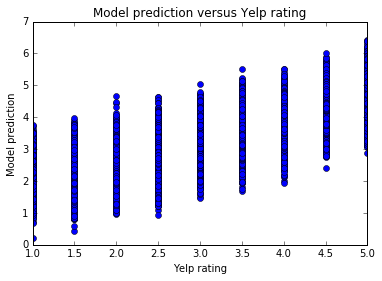

In [8]:
%matplotlib inline
import matplotlib.pylab as plt

plt.plot(y_total, y_pred, "o")
plt.title('Model prediction versus Yelp rating')
plt.xlabel("Yelp rating"); plt.ylabel("Model prediction")

In [9]:
star1 = []
star1_pred = []
star2 = []
star2_pred = []
star3 = []
star3_pred = []
star4 = []
star4_pred = []
star5 = []
star5_pred = []
star1h = []
star1h_pred = []
star2h = []
star2h_pred = []
star3h = []
star3h_pred = []
star4h = []
star4h_pred = []
star5h = []
star5h_pred = []
for i in range(len(y_total)):
    if y_total[i] == 5:
        star5.append(y_total[i])
        star5_pred.append(y_pred[i])
    if y_total[i] == 4:
        star4.append(y_total[i])
        star4_pred.append(y_pred[i])
    if y_total[i] == 3:
        star3.append(y_total[i])
        star3_pred.append(y_pred[i])
    if y_total[i] == 2:
        star2.append(y_total[i])
        star2_pred.append(y_pred[i])
    if y_total[i] == 1:
        star1.append(y_total[i])
        star1_pred.append(y_pred[i])
        
for i in range(len(y_total)):
    if y_total[i] == 4.5:
        star4h.append(y_total[i])
        star4h_pred.append(y_pred[i])
    if y_total[i] == 3.5:
        star3h.append(y_total[i])
        star3h_pred.append(y_pred[i])
    if y_total[i] == 2.5:
        star2h.append(y_total[i])
        star2h_pred.append(y_pred[i])
    if y_total[i] == 1.5:
        star1h.append(y_total[i])
        star1h_pred.append(y_pred[i])

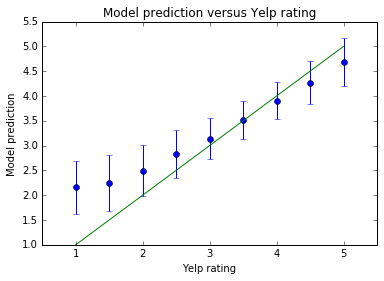

In [14]:
star5_pred = np.array(star5_pred)
star4_pred = np.array(star4_pred)
star3_pred = np.array(star3_pred)
star2_pred = np.array(star2_pred)
star1_pred = np.array(star1_pred)

star4h_pred = np.array(star4h_pred)
star3h_pred = np.array(star3h_pred)
star2h_pred = np.array(star2h_pred)
star1h_pred = np.array(star1h_pred)

stars_array = [1, 1.5, 2, 2.5, 3, 3.5, 4, 4.5, 5]
stars_mean = [star1_pred.mean(), star1h_pred.mean(), star2_pred.mean(), star2h_pred.mean(), 
              star3_pred.mean(), star3h_pred.mean(), star4_pred.mean(), star4h_pred.mean(), star5_pred.mean()]
stars_std = [star1_pred.std(), star1h_pred.std(), star2_pred.std(), star2h_pred.std(), 
             star3_pred.std(), star3h_pred.std(), star4_pred.std(), star4h_pred.std(), star5_pred.std()]

plt.errorbar(stars_array, stars_mean, yerr=stars_std, fmt='o')
plt.plot(stars_array, stars_array, color='g')
plt.title('Model prediction versus Yelp rating')
plt.xlabel("Yelp rating")
plt.ylabel("Model prediction")
plt.xlim(0.5,5.5)
#plt.figure(figsize=(30,30))
plt.savefig('model.png', dpi = 300)

In [104]:
print y_pred[0:100]
print y_total[0:100]

[[ 3.81968551]
 [ 3.89156293]
 [ 4.83262014]
 [ 3.37182229]
 [ 2.5380498 ]
 [ 4.49520034]
 [ 3.89377281]
 [ 3.93822775]
 [ 3.00439926]
 [ 3.86229617]
 [ 2.19212123]
 [ 4.32805001]
 [ 4.32428933]
 [ 4.45331107]
 [ 3.54125173]
 [ 3.62921626]
 [ 3.27567287]
 [ 3.85301879]
 [ 3.72469512]
 [ 4.45946261]
 [ 3.48640822]
 [ 3.24295389]
 [ 3.25422697]
 [ 2.01693093]
 [ 5.19594244]
 [ 3.16249173]
 [ 2.79043772]
 [ 3.52622751]
 [ 2.89710168]
 [ 4.56697134]
 [ 3.91837527]
 [ 3.29452301]
 [ 3.52241845]
 [ 3.56167276]
 [ 2.90644461]
 [ 3.64347266]
 [ 2.89787647]
 [ 2.84700184]
 [ 4.2353792 ]
 [ 1.89877768]
 [ 3.67904217]
 [ 3.70548305]
 [ 4.68142253]
 [ 3.87101382]
 [ 3.65882529]
 [ 2.71840296]
 [ 4.53483412]
 [ 2.23332294]
 [ 1.99647746]
 [ 3.73115641]
 [ 3.57191241]
 [ 3.2888793 ]
 [ 3.38875644]
 [ 3.80775521]
 [ 2.59149428]
 [ 3.50228803]
 [ 4.10726942]
 [ 4.18212408]
 [ 3.82264978]
 [ 2.64892267]
 [ 2.86621036]
 [ 3.96888342]
 [ 3.10494311]
 [ 3.35592296]
 [ 2.99639806]
 [ 3.86142006]
 [ 3.02128

In [4]:
business_id = u'McikHxxEqZ2X0joaRNKlaw' 
business_myself = business[business.index == business_id]
stars_predict = model_myself.predict(business_myself)
print stars_predict

[[ 3.81675846]]


In [27]:
reviews_myself = business_myself['reviews'].iloc[0]
attributes_myself = business_myself['attributes_combined'].iloc[0]

print categories_myself
print attributes_myself

business_id
McikHxxEqZ2X0joaRNKlaw    ['Food', 'American (Traditional)', 'Breweries'...
Name: categories, dtype: object
 & Outdoor Seating & Parking.lot & Waiter Service & Accepts Credit Cards & Take-out & Takes Reservations & Wheelchair Accessible & Good For.dinner & Good for Kids & Has TV & Ambience.casual & Good For Groups


In [33]:
att_to_add = ['Ambience.divey', 'Ambience.hipster']
perception_to_add = ['good food', 'good prices'] * 5
food_to_add = ['bbq sauce', 'bean cheese burrito'] * 5

att_to_add = "& " + ' & '.join(att_to_add)
attributes_myself = attributes_myself + att_to_add
print attributes_myself

rev_to_add = perception_to_add + food_to_add
rev_to_add = ' '.join(rev_to_add)
reviews_myself = reviews_myself + rev_to_add
#print reviews_myself

business_myself['attributes_combined'].iloc[0] = attributes_myself
business_myself['reviews'].iloc[0] = reviews_myself

print business_myself['attributes_combined']

 & Outdoor Seating & Parking.lot & Waiter Service & Accepts Credit Cards & Take-out & Takes Reservations & Wheelchair Accessible & Good For.dinner & Good for Kids & Has TV & Ambience.casual & Good For Groups& Ambience.divey & Ambience.hipster& Ambience.divey & Ambience.hipster& Ambience.divey & Ambience.hipster& Ambience.divey & Ambience.hipster& Ambience.divey & Ambience.hipster
business_id
McikHxxEqZ2X0joaRNKlaw     & Outdoor Seating & Parking.lot & Waiter Serv...
Name: attributes_combined, dtype: object


/Applications/anaconda/lib/python2.7/site-packages/pandas/core/indexing.py:132: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)
/Applications/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Applications/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [3]:
strings = ['blah blah', 'blah']
string_joined = ''.join(strings)
print string_joined

blah blahblah


In [51]:
my_list = [u'bacon', u'bacon wrapped dates', u'bbq chicken pizza']
my_list_ascii = [x.encode('UTF8') for x in my_list]
print my_list
print my_list_ascii

[u'bacon', u'bacon wrapped dates', u'bbq chicken pizza']
['bacon', 'bacon wrapped dates', 'bbq chicken pizza']
